# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = '/data'
!pip install matplotlib==2.0.2
# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

    100% |████████████████████████████████| 14.6MB 46kB/s  eta 0:00:01
  Found existing installation: matplotlib 2.1.0
    Uninstalling matplotlib-2.1.0:
      Successfully uninstalled matplotlib-2.1.0
You are using pip version 9.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

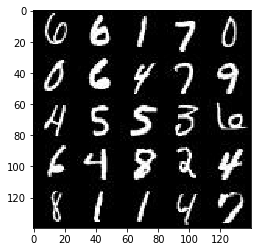

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

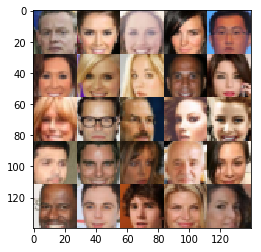

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function

    return (tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels), name='input_real'), 
            tf.placeholder(tf.float32, shape=(None, z_dim), name='input_z'), 
            tf.placeholder(tf.float32, name='learning_rate'))


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 478, in start\n    self.io_loop.start()', 'File "/opt/conda/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start\n    super(ZMQIOLoop, self).start()', 'File "/opt/co

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [16]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    alpha=0.2
    keep_prob = 0.6
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28X28x3
        x1 = tf.layers.conv2d(images, 128, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x1 = tf.maximum(alpha * x1, x1)
#         x1 = tf.nn.dropout(x1, keep_prob)
        # 14X14x128
        
        x2 = tf.layers.conv2d(x1, 256, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
#         x2 = tf.nn.dropout(x2, keep_prob)
        # 7X7x256
        
        x3 = tf.layers.conv2d(x2, 512, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x2, training=True)
        x3 = tf.maximum(alpha * x2, x2)
        x3 = tf.nn.dropout(x3, keep_prob)
        # 4X4x512

        # Flatten it
        flat = tf.reshape(x3, (-1, 4*4*512))
        logits = tf.layers.dense(flat, 1, kernel_initializer=tf.truncated_normal_initializer(stddev=0.02))
        out = tf.sigmoid(logits)

        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [17]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    alpha=0.2
    
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 2*2*1024, kernel_initializer=tf.truncated_normal_initializer(stddev=0.02))
        
        # Reshape it to start the convolutional stack
        
        x1 = tf.reshape(x1, (-1, 2, 2, 1024))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 2x2x1024 now
        
        x2 = tf.layers.conv2d_transpose(x1, 512, 5, strides=2, padding='valid', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x512 now
        
        x3 = tf.layers.conv2d_transpose(x2, 256, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14x14x256 now
        
        x4 = tf.layers.conv2d_transpose(x3, 128, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha * x4, x4)
        # 28x28x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 5, strides=1, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
        return out
    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [18]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    alpha=0.2
    smooth=0.1
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [19]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [20]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [21]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    input_real, input_z, learn_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    saver = tf.train.Saver()
    steps = 0
    print_every = 10
    show_every = 100
    losses = []
    n_images = 25
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                batch_images = batch_images * 2
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, input_real: batch_images, learn_rate: learning_rate})
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                    
                if steps % show_every == 0:
                    show_generator_output(sess, n_images, input_z, data_shape[3], data_image_mode)
                    
        saver.save(sess, './checkpoints/generator.ckpt')
        
    return losses              
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.5253... Generator Loss: 0.5721
Epoch 1/2... Discriminator Loss: 0.9117... Generator Loss: 1.2377
Epoch 1/2... Discriminator Loss: 0.7328... Generator Loss: 1.5135
Epoch 1/2... Discriminator Loss: 0.6717... Generator Loss: 1.9493
Epoch 1/2... Discriminator Loss: 0.7128... Generator Loss: 1.7277
Epoch 1/2... Discriminator Loss: 0.9778... Generator Loss: 1.3702
Epoch 1/2... Discriminator Loss: 0.9095... Generator Loss: 1.4303
Epoch 1/2... Discriminator Loss: 1.3293... Generator Loss: 0.8562
Epoch 1/2... Discriminator Loss: 1.1209... Generator Loss: 1.2877
Epoch 1/2... Discriminator Loss: 1.2539... Generator Loss: 0.9879


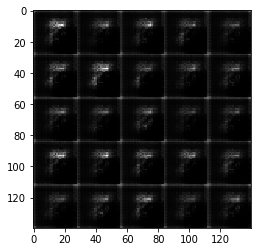

Epoch 1/2... Discriminator Loss: 1.2476... Generator Loss: 0.8891
Epoch 1/2... Discriminator Loss: 1.2355... Generator Loss: 1.0724
Epoch 1/2... Discriminator Loss: 1.2880... Generator Loss: 0.8845
Epoch 1/2... Discriminator Loss: 1.1301... Generator Loss: 0.9593
Epoch 1/2... Discriminator Loss: 1.1262... Generator Loss: 1.0110
Epoch 1/2... Discriminator Loss: 1.0953... Generator Loss: 1.1606
Epoch 1/2... Discriminator Loss: 1.0388... Generator Loss: 1.1512
Epoch 1/2... Discriminator Loss: 1.1122... Generator Loss: 1.0091
Epoch 1/2... Discriminator Loss: 1.0906... Generator Loss: 0.8683
Epoch 1/2... Discriminator Loss: 1.2199... Generator Loss: 1.1067


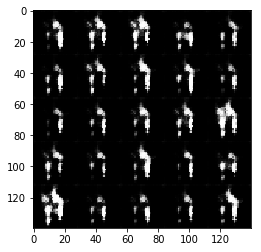

Epoch 1/2... Discriminator Loss: 1.0981... Generator Loss: 1.1188
Epoch 1/2... Discriminator Loss: 1.2347... Generator Loss: 1.0954
Epoch 1/2... Discriminator Loss: 1.3018... Generator Loss: 0.9494
Epoch 1/2... Discriminator Loss: 1.1313... Generator Loss: 0.9446
Epoch 1/2... Discriminator Loss: 1.2751... Generator Loss: 0.9801
Epoch 1/2... Discriminator Loss: 1.1137... Generator Loss: 1.0258
Epoch 1/2... Discriminator Loss: 1.2015... Generator Loss: 1.1190
Epoch 1/2... Discriminator Loss: 1.2311... Generator Loss: 0.9345
Epoch 1/2... Discriminator Loss: 1.2782... Generator Loss: 1.0886
Epoch 1/2... Discriminator Loss: 1.2148... Generator Loss: 0.8828


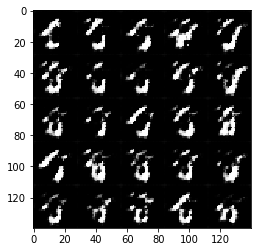

Epoch 1/2... Discriminator Loss: 1.1342... Generator Loss: 1.1844
Epoch 1/2... Discriminator Loss: 1.1648... Generator Loss: 1.1334
Epoch 1/2... Discriminator Loss: 1.2607... Generator Loss: 1.1092
Epoch 1/2... Discriminator Loss: 1.1073... Generator Loss: 1.0373
Epoch 1/2... Discriminator Loss: 1.1730... Generator Loss: 1.0400
Epoch 1/2... Discriminator Loss: 1.3672... Generator Loss: 0.8611
Epoch 1/2... Discriminator Loss: 1.2684... Generator Loss: 0.9363
Epoch 1/2... Discriminator Loss: 1.2702... Generator Loss: 0.9872
Epoch 1/2... Discriminator Loss: 1.2031... Generator Loss: 0.9466
Epoch 1/2... Discriminator Loss: 1.1290... Generator Loss: 1.0098


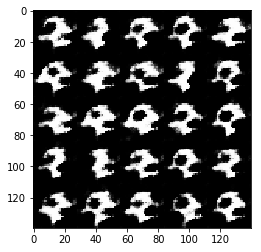

Epoch 1/2... Discriminator Loss: 1.0383... Generator Loss: 1.3686
Epoch 1/2... Discriminator Loss: 1.1857... Generator Loss: 0.9850
Epoch 1/2... Discriminator Loss: 1.3368... Generator Loss: 0.9744
Epoch 1/2... Discriminator Loss: 1.3125... Generator Loss: 0.9474
Epoch 1/2... Discriminator Loss: 1.1332... Generator Loss: 1.1088
Epoch 1/2... Discriminator Loss: 1.1426... Generator Loss: 1.0367
Epoch 1/2... Discriminator Loss: 1.3893... Generator Loss: 0.7577
Epoch 1/2... Discriminator Loss: 1.2803... Generator Loss: 0.9412
Epoch 1/2... Discriminator Loss: 1.2104... Generator Loss: 1.0360
Epoch 1/2... Discriminator Loss: 1.2472... Generator Loss: 1.0003


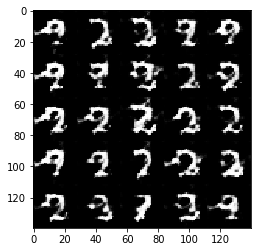

Epoch 1/2... Discriminator Loss: 1.2766... Generator Loss: 1.0982
Epoch 1/2... Discriminator Loss: 1.3578... Generator Loss: 0.9573
Epoch 1/2... Discriminator Loss: 1.3141... Generator Loss: 0.8571
Epoch 1/2... Discriminator Loss: 1.1812... Generator Loss: 1.0331
Epoch 1/2... Discriminator Loss: 1.0942... Generator Loss: 1.1853
Epoch 1/2... Discriminator Loss: 1.2829... Generator Loss: 0.9655
Epoch 1/2... Discriminator Loss: 1.1651... Generator Loss: 1.0852
Epoch 1/2... Discriminator Loss: 1.1746... Generator Loss: 1.0472
Epoch 1/2... Discriminator Loss: 1.4150... Generator Loss: 0.8991
Epoch 1/2... Discriminator Loss: 1.3138... Generator Loss: 0.8370


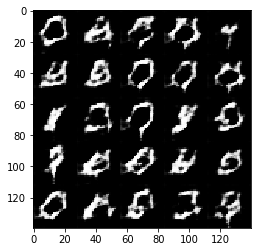

Epoch 1/2... Discriminator Loss: 1.2989... Generator Loss: 1.1407
Epoch 1/2... Discriminator Loss: 1.2883... Generator Loss: 0.9033
Epoch 1/2... Discriminator Loss: 1.2395... Generator Loss: 1.0201
Epoch 1/2... Discriminator Loss: 1.2977... Generator Loss: 0.8982
Epoch 1/2... Discriminator Loss: 1.2962... Generator Loss: 0.8721
Epoch 1/2... Discriminator Loss: 1.3339... Generator Loss: 0.8309
Epoch 1/2... Discriminator Loss: 1.2182... Generator Loss: 0.9766
Epoch 1/2... Discriminator Loss: 1.2075... Generator Loss: 0.8899
Epoch 1/2... Discriminator Loss: 1.2754... Generator Loss: 0.7820
Epoch 1/2... Discriminator Loss: 1.2878... Generator Loss: 0.8269


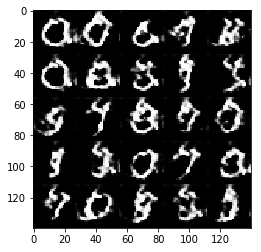

Epoch 1/2... Discriminator Loss: 1.1951... Generator Loss: 0.8782
Epoch 1/2... Discriminator Loss: 1.3609... Generator Loss: 0.9267
Epoch 1/2... Discriminator Loss: 1.2479... Generator Loss: 0.9102
Epoch 1/2... Discriminator Loss: 1.2599... Generator Loss: 0.9142
Epoch 1/2... Discriminator Loss: 1.2130... Generator Loss: 0.9035
Epoch 1/2... Discriminator Loss: 1.2802... Generator Loss: 0.9396
Epoch 1/2... Discriminator Loss: 1.2984... Generator Loss: 0.8743
Epoch 1/2... Discriminator Loss: 1.3398... Generator Loss: 0.7791
Epoch 1/2... Discriminator Loss: 1.2161... Generator Loss: 0.9208
Epoch 1/2... Discriminator Loss: 1.3673... Generator Loss: 0.9779


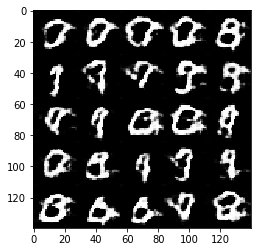

Epoch 1/2... Discriminator Loss: 1.2169... Generator Loss: 0.9742
Epoch 1/2... Discriminator Loss: 1.2542... Generator Loss: 0.9221
Epoch 1/2... Discriminator Loss: 1.3725... Generator Loss: 0.7693
Epoch 1/2... Discriminator Loss: 1.3578... Generator Loss: 0.7856
Epoch 1/2... Discriminator Loss: 1.3089... Generator Loss: 0.9304
Epoch 1/2... Discriminator Loss: 1.2538... Generator Loss: 0.9587
Epoch 1/2... Discriminator Loss: 1.3512... Generator Loss: 0.9108
Epoch 1/2... Discriminator Loss: 1.3320... Generator Loss: 0.9645
Epoch 1/2... Discriminator Loss: 1.2400... Generator Loss: 0.9620
Epoch 1/2... Discriminator Loss: 1.2947... Generator Loss: 0.8942


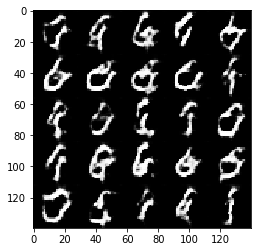

Epoch 1/2... Discriminator Loss: 1.2922... Generator Loss: 0.8668
Epoch 1/2... Discriminator Loss: 1.2822... Generator Loss: 0.8173
Epoch 1/2... Discriminator Loss: 1.3353... Generator Loss: 0.8891
Epoch 1/2... Discriminator Loss: 1.3375... Generator Loss: 0.9387
Epoch 1/2... Discriminator Loss: 1.3403... Generator Loss: 0.8817
Epoch 1/2... Discriminator Loss: 1.2417... Generator Loss: 0.8920
Epoch 1/2... Discriminator Loss: 1.2902... Generator Loss: 0.9120
Epoch 1/2... Discriminator Loss: 1.3125... Generator Loss: 0.9239
Epoch 1/2... Discriminator Loss: 1.3580... Generator Loss: 0.8118
Epoch 1/2... Discriminator Loss: 1.2647... Generator Loss: 0.8432


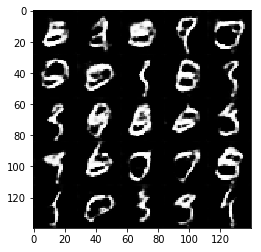

Epoch 1/2... Discriminator Loss: 1.3189... Generator Loss: 0.8877
Epoch 1/2... Discriminator Loss: 1.3426... Generator Loss: 0.8863
Epoch 1/2... Discriminator Loss: 1.2867... Generator Loss: 0.8705
Epoch 1/2... Discriminator Loss: 1.3776... Generator Loss: 0.8782
Epoch 1/2... Discriminator Loss: 1.3168... Generator Loss: 0.8458
Epoch 1/2... Discriminator Loss: 1.2740... Generator Loss: 0.8768
Epoch 1/2... Discriminator Loss: 1.3165... Generator Loss: 0.8887
Epoch 1/2... Discriminator Loss: 1.2960... Generator Loss: 0.8733
Epoch 1/2... Discriminator Loss: 1.2810... Generator Loss: 0.7371
Epoch 1/2... Discriminator Loss: 1.2962... Generator Loss: 0.8528


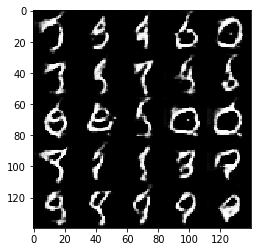

Epoch 1/2... Discriminator Loss: 1.3087... Generator Loss: 0.8822
Epoch 1/2... Discriminator Loss: 1.3120... Generator Loss: 0.7984
Epoch 1/2... Discriminator Loss: 1.2642... Generator Loss: 0.8144
Epoch 1/2... Discriminator Loss: 1.2665... Generator Loss: 0.7580
Epoch 1/2... Discriminator Loss: 1.2824... Generator Loss: 0.8737
Epoch 1/2... Discriminator Loss: 1.4005... Generator Loss: 0.7786
Epoch 1/2... Discriminator Loss: 1.2711... Generator Loss: 0.9171
Epoch 1/2... Discriminator Loss: 1.3017... Generator Loss: 0.8255
Epoch 1/2... Discriminator Loss: 1.3476... Generator Loss: 0.8716
Epoch 1/2... Discriminator Loss: 1.3917... Generator Loss: 0.9678


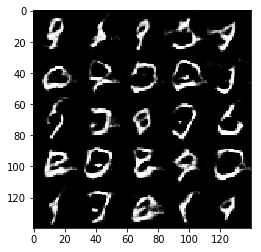

Epoch 1/2... Discriminator Loss: 1.2802... Generator Loss: 0.8169
Epoch 1/2... Discriminator Loss: 1.2841... Generator Loss: 0.8839
Epoch 1/2... Discriminator Loss: 1.2287... Generator Loss: 0.8952
Epoch 1/2... Discriminator Loss: 1.3431... Generator Loss: 0.8449
Epoch 1/2... Discriminator Loss: 1.2547... Generator Loss: 0.8518
Epoch 1/2... Discriminator Loss: 1.3192... Generator Loss: 0.8618
Epoch 1/2... Discriminator Loss: 1.4143... Generator Loss: 0.8144
Epoch 1/2... Discriminator Loss: 1.4204... Generator Loss: 0.8726
Epoch 1/2... Discriminator Loss: 1.2889... Generator Loss: 0.7937
Epoch 1/2... Discriminator Loss: 1.3187... Generator Loss: 0.8674


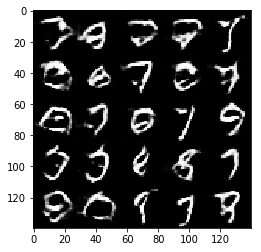

Epoch 1/2... Discriminator Loss: 1.3332... Generator Loss: 0.8826
Epoch 1/2... Discriminator Loss: 1.2745... Generator Loss: 1.0063
Epoch 1/2... Discriminator Loss: 1.2641... Generator Loss: 0.8651
Epoch 1/2... Discriminator Loss: 1.3190... Generator Loss: 0.8779
Epoch 1/2... Discriminator Loss: 1.3047... Generator Loss: 0.9888
Epoch 1/2... Discriminator Loss: 1.3351... Generator Loss: 0.8860
Epoch 1/2... Discriminator Loss: 1.3011... Generator Loss: 0.9564
Epoch 1/2... Discriminator Loss: 1.3979... Generator Loss: 0.7401
Epoch 1/2... Discriminator Loss: 1.2579... Generator Loss: 0.9485
Epoch 1/2... Discriminator Loss: 1.3081... Generator Loss: 0.9858


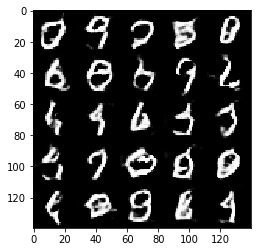

Epoch 1/2... Discriminator Loss: 1.3254... Generator Loss: 0.8444
Epoch 1/2... Discriminator Loss: 1.3873... Generator Loss: 0.8819
Epoch 1/2... Discriminator Loss: 1.3335... Generator Loss: 0.8600
Epoch 1/2... Discriminator Loss: 1.2157... Generator Loss: 0.9088
Epoch 1/2... Discriminator Loss: 1.3490... Generator Loss: 0.8771
Epoch 1/2... Discriminator Loss: 1.3328... Generator Loss: 0.8786
Epoch 1/2... Discriminator Loss: 1.2782... Generator Loss: 0.8137
Epoch 1/2... Discriminator Loss: 1.2467... Generator Loss: 0.9075
Epoch 1/2... Discriminator Loss: 1.3322... Generator Loss: 0.8827
Epoch 1/2... Discriminator Loss: 1.2723... Generator Loss: 0.8622


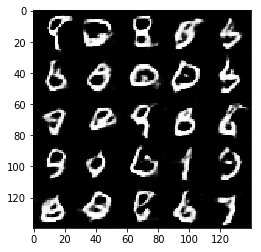

Epoch 1/2... Discriminator Loss: 1.4029... Generator Loss: 0.6971
Epoch 1/2... Discriminator Loss: 1.3129... Generator Loss: 0.9380
Epoch 1/2... Discriminator Loss: 1.3083... Generator Loss: 0.8267
Epoch 1/2... Discriminator Loss: 1.4256... Generator Loss: 0.7635
Epoch 1/2... Discriminator Loss: 1.2988... Generator Loss: 0.8654
Epoch 1/2... Discriminator Loss: 1.3752... Generator Loss: 0.9438
Epoch 1/2... Discriminator Loss: 1.3380... Generator Loss: 0.8816
Epoch 1/2... Discriminator Loss: 1.3283... Generator Loss: 0.7908
Epoch 1/2... Discriminator Loss: 1.4112... Generator Loss: 0.7663
Epoch 1/2... Discriminator Loss: 1.3315... Generator Loss: 1.0137


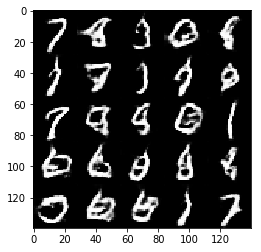

Epoch 1/2... Discriminator Loss: 1.2908... Generator Loss: 0.9189
Epoch 1/2... Discriminator Loss: 1.3328... Generator Loss: 0.8115
Epoch 1/2... Discriminator Loss: 1.2759... Generator Loss: 0.8026
Epoch 1/2... Discriminator Loss: 1.2167... Generator Loss: 0.8956
Epoch 1/2... Discriminator Loss: 1.2924... Generator Loss: 0.8377
Epoch 1/2... Discriminator Loss: 1.2848... Generator Loss: 0.8975
Epoch 1/2... Discriminator Loss: 1.3149... Generator Loss: 0.8902
Epoch 1/2... Discriminator Loss: 1.3613... Generator Loss: 0.8684
Epoch 1/2... Discriminator Loss: 1.3372... Generator Loss: 0.8716
Epoch 1/2... Discriminator Loss: 1.2561... Generator Loss: 0.9052


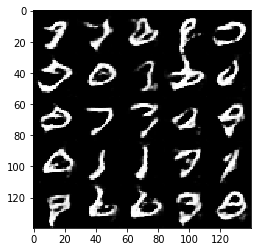

Epoch 1/2... Discriminator Loss: 1.2678... Generator Loss: 0.8430
Epoch 1/2... Discriminator Loss: 1.2859... Generator Loss: 0.8938
Epoch 1/2... Discriminator Loss: 1.3454... Generator Loss: 0.9163
Epoch 1/2... Discriminator Loss: 1.3797... Generator Loss: 0.8336
Epoch 1/2... Discriminator Loss: 1.2969... Generator Loss: 0.8524
Epoch 1/2... Discriminator Loss: 1.3094... Generator Loss: 0.8659
Epoch 1/2... Discriminator Loss: 1.2846... Generator Loss: 0.8609
Epoch 1/2... Discriminator Loss: 1.3923... Generator Loss: 0.7863
Epoch 1/2... Discriminator Loss: 1.3410... Generator Loss: 0.8428
Epoch 1/2... Discriminator Loss: 1.3169... Generator Loss: 0.8247


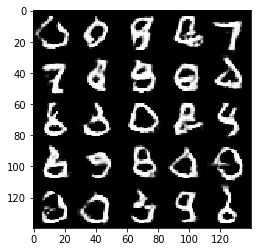

Epoch 1/2... Discriminator Loss: 1.3452... Generator Loss: 0.8076
Epoch 1/2... Discriminator Loss: 1.4001... Generator Loss: 1.0261
Epoch 1/2... Discriminator Loss: 1.3106... Generator Loss: 0.8809
Epoch 1/2... Discriminator Loss: 1.2775... Generator Loss: 0.8901
Epoch 1/2... Discriminator Loss: 1.2957... Generator Loss: 0.7099
Epoch 1/2... Discriminator Loss: 1.3131... Generator Loss: 0.8988
Epoch 1/2... Discriminator Loss: 1.3776... Generator Loss: 0.8508
Epoch 2/2... Discriminator Loss: 1.3072... Generator Loss: 0.9386
Epoch 2/2... Discriminator Loss: 1.2285... Generator Loss: 0.9823
Epoch 2/2... Discriminator Loss: 1.3308... Generator Loss: 0.9142


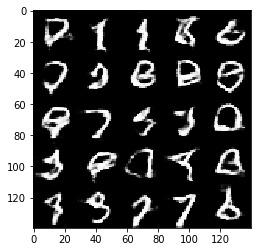

Epoch 2/2... Discriminator Loss: 1.2870... Generator Loss: 0.9230
Epoch 2/2... Discriminator Loss: 1.3098... Generator Loss: 0.9085
Epoch 2/2... Discriminator Loss: 1.3228... Generator Loss: 0.7242
Epoch 2/2... Discriminator Loss: 1.3514... Generator Loss: 0.8010
Epoch 2/2... Discriminator Loss: 1.3945... Generator Loss: 0.8652
Epoch 2/2... Discriminator Loss: 1.3846... Generator Loss: 0.8445
Epoch 2/2... Discriminator Loss: 1.3117... Generator Loss: 1.0374
Epoch 2/2... Discriminator Loss: 1.3455... Generator Loss: 0.7945
Epoch 2/2... Discriminator Loss: 1.4466... Generator Loss: 0.7587
Epoch 2/2... Discriminator Loss: 1.2965... Generator Loss: 0.7974


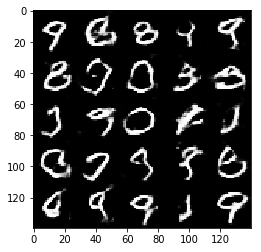

Epoch 2/2... Discriminator Loss: 1.4492... Generator Loss: 0.8408
Epoch 2/2... Discriminator Loss: 1.2848... Generator Loss: 0.9995
Epoch 2/2... Discriminator Loss: 1.2037... Generator Loss: 0.8851
Epoch 2/2... Discriminator Loss: 1.3177... Generator Loss: 1.0375
Epoch 2/2... Discriminator Loss: 1.3863... Generator Loss: 0.7742
Epoch 2/2... Discriminator Loss: 1.3811... Generator Loss: 0.7575
Epoch 2/2... Discriminator Loss: 1.3529... Generator Loss: 0.7123
Epoch 2/2... Discriminator Loss: 1.3161... Generator Loss: 1.1171
Epoch 2/2... Discriminator Loss: 1.3158... Generator Loss: 0.9323
Epoch 2/2... Discriminator Loss: 1.3860... Generator Loss: 0.9174


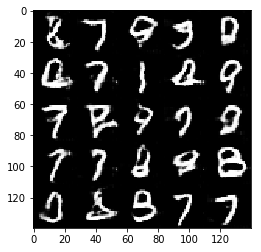

Epoch 2/2... Discriminator Loss: 1.2365... Generator Loss: 0.8865
Epoch 2/2... Discriminator Loss: 1.3214... Generator Loss: 0.6912
Epoch 2/2... Discriminator Loss: 1.2957... Generator Loss: 0.7523
Epoch 2/2... Discriminator Loss: 1.3160... Generator Loss: 0.8893
Epoch 2/2... Discriminator Loss: 1.4547... Generator Loss: 0.6276
Epoch 2/2... Discriminator Loss: 1.4010... Generator Loss: 1.1194
Epoch 2/2... Discriminator Loss: 1.3024... Generator Loss: 0.8895
Epoch 2/2... Discriminator Loss: 1.2992... Generator Loss: 0.8160
Epoch 2/2... Discriminator Loss: 1.3313... Generator Loss: 0.9398
Epoch 2/2... Discriminator Loss: 1.2490... Generator Loss: 0.9345


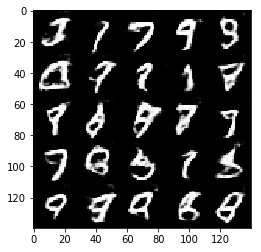

Epoch 2/2... Discriminator Loss: 1.3347... Generator Loss: 0.9485
Epoch 2/2... Discriminator Loss: 1.2796... Generator Loss: 0.8445
Epoch 2/2... Discriminator Loss: 1.3021... Generator Loss: 0.8344
Epoch 2/2... Discriminator Loss: 1.2322... Generator Loss: 0.8226
Epoch 2/2... Discriminator Loss: 1.3418... Generator Loss: 0.8737
Epoch 2/2... Discriminator Loss: 1.3144... Generator Loss: 0.8028
Epoch 2/2... Discriminator Loss: 1.2595... Generator Loss: 0.9247
Epoch 2/2... Discriminator Loss: 1.3156... Generator Loss: 0.7691
Epoch 2/2... Discriminator Loss: 1.2435... Generator Loss: 0.8049
Epoch 2/2... Discriminator Loss: 1.4150... Generator Loss: 0.7786


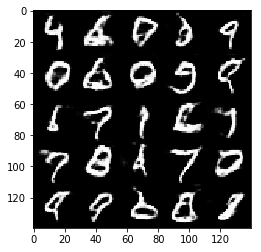

Epoch 2/2... Discriminator Loss: 1.2629... Generator Loss: 0.9375
Epoch 2/2... Discriminator Loss: 1.3059... Generator Loss: 0.8345
Epoch 2/2... Discriminator Loss: 1.3978... Generator Loss: 0.8121
Epoch 2/2... Discriminator Loss: 1.2913... Generator Loss: 0.9323
Epoch 2/2... Discriminator Loss: 1.3419... Generator Loss: 0.8718
Epoch 2/2... Discriminator Loss: 1.2821... Generator Loss: 0.8725
Epoch 2/2... Discriminator Loss: 1.1995... Generator Loss: 0.9436
Epoch 2/2... Discriminator Loss: 1.3859... Generator Loss: 0.8422
Epoch 2/2... Discriminator Loss: 1.3154... Generator Loss: 0.7543
Epoch 2/2... Discriminator Loss: 1.2924... Generator Loss: 0.7992


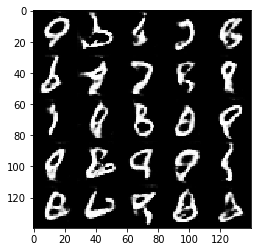

Epoch 2/2... Discriminator Loss: 1.2059... Generator Loss: 0.8511
Epoch 2/2... Discriminator Loss: 1.3959... Generator Loss: 0.8764
Epoch 2/2... Discriminator Loss: 1.3328... Generator Loss: 0.8328
Epoch 2/2... Discriminator Loss: 1.3058... Generator Loss: 1.0585
Epoch 2/2... Discriminator Loss: 1.3917... Generator Loss: 0.6925
Epoch 2/2... Discriminator Loss: 1.3976... Generator Loss: 0.8494
Epoch 2/2... Discriminator Loss: 1.2618... Generator Loss: 0.8516
Epoch 2/2... Discriminator Loss: 1.3421... Generator Loss: 0.8740
Epoch 2/2... Discriminator Loss: 1.3304... Generator Loss: 0.8263
Epoch 2/2... Discriminator Loss: 1.3214... Generator Loss: 0.8108


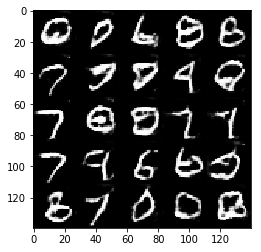

Epoch 2/2... Discriminator Loss: 1.2639... Generator Loss: 1.0488
Epoch 2/2... Discriminator Loss: 1.2266... Generator Loss: 0.8978
Epoch 2/2... Discriminator Loss: 1.3336... Generator Loss: 0.8414
Epoch 2/2... Discriminator Loss: 1.3302... Generator Loss: 0.8302
Epoch 2/2... Discriminator Loss: 1.2459... Generator Loss: 0.9101
Epoch 2/2... Discriminator Loss: 1.3322... Generator Loss: 0.6789
Epoch 2/2... Discriminator Loss: 1.2945... Generator Loss: 0.7956
Epoch 2/2... Discriminator Loss: 1.3942... Generator Loss: 0.7900
Epoch 2/2... Discriminator Loss: 1.2900... Generator Loss: 0.8331
Epoch 2/2... Discriminator Loss: 1.2868... Generator Loss: 0.9112


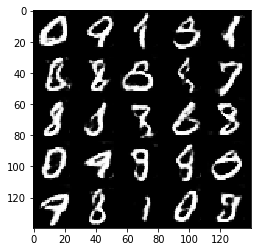

Epoch 2/2... Discriminator Loss: 1.2936... Generator Loss: 0.9275
Epoch 2/2... Discriminator Loss: 1.3330... Generator Loss: 0.8405
Epoch 2/2... Discriminator Loss: 1.3361... Generator Loss: 0.7377
Epoch 2/2... Discriminator Loss: 1.2983... Generator Loss: 0.7891
Epoch 2/2... Discriminator Loss: 1.3187... Generator Loss: 0.7621
Epoch 2/2... Discriminator Loss: 1.3074... Generator Loss: 0.8689
Epoch 2/2... Discriminator Loss: 1.2794... Generator Loss: 0.8641
Epoch 2/2... Discriminator Loss: 1.2855... Generator Loss: 0.7753
Epoch 2/2... Discriminator Loss: 1.2766... Generator Loss: 0.8677
Epoch 2/2... Discriminator Loss: 1.3805... Generator Loss: 0.7180


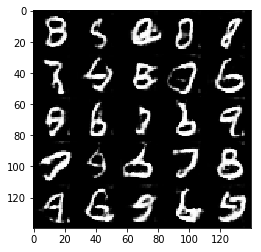

Epoch 2/2... Discriminator Loss: 1.3558... Generator Loss: 0.8651
Epoch 2/2... Discriminator Loss: 1.3674... Generator Loss: 0.8524
Epoch 2/2... Discriminator Loss: 1.2779... Generator Loss: 0.8326
Epoch 2/2... Discriminator Loss: 1.2880... Generator Loss: 0.9294
Epoch 2/2... Discriminator Loss: 1.2057... Generator Loss: 0.7719
Epoch 2/2... Discriminator Loss: 1.2767... Generator Loss: 0.8328
Epoch 2/2... Discriminator Loss: 1.3269... Generator Loss: 0.7695
Epoch 2/2... Discriminator Loss: 1.3031... Generator Loss: 0.8280
Epoch 2/2... Discriminator Loss: 1.3353... Generator Loss: 0.8836
Epoch 2/2... Discriminator Loss: 1.3173... Generator Loss: 0.8813


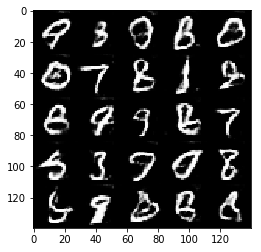

Epoch 2/2... Discriminator Loss: 1.2501... Generator Loss: 0.9092
Epoch 2/2... Discriminator Loss: 1.3240... Generator Loss: 1.0966
Epoch 2/2... Discriminator Loss: 1.3451... Generator Loss: 0.7471
Epoch 2/2... Discriminator Loss: 1.2883... Generator Loss: 1.0350
Epoch 2/2... Discriminator Loss: 1.2635... Generator Loss: 0.7775
Epoch 2/2... Discriminator Loss: 1.2468... Generator Loss: 0.9278
Epoch 2/2... Discriminator Loss: 1.2246... Generator Loss: 0.9657
Epoch 2/2... Discriminator Loss: 1.3110... Generator Loss: 0.9737
Epoch 2/2... Discriminator Loss: 1.2926... Generator Loss: 0.8995
Epoch 2/2... Discriminator Loss: 1.4059... Generator Loss: 0.9335


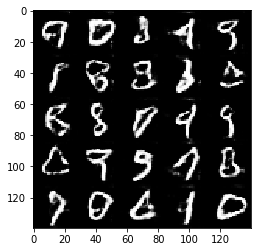

Epoch 2/2... Discriminator Loss: 1.3126... Generator Loss: 0.9388
Epoch 2/2... Discriminator Loss: 1.2831... Generator Loss: 0.9615
Epoch 2/2... Discriminator Loss: 1.2667... Generator Loss: 0.7532
Epoch 2/2... Discriminator Loss: 1.3619... Generator Loss: 0.9418
Epoch 2/2... Discriminator Loss: 1.3004... Generator Loss: 1.0912
Epoch 2/2... Discriminator Loss: 1.3282... Generator Loss: 0.8283
Epoch 2/2... Discriminator Loss: 1.2755... Generator Loss: 0.8469
Epoch 2/2... Discriminator Loss: 1.2897... Generator Loss: 0.8791
Epoch 2/2... Discriminator Loss: 1.3828... Generator Loss: 0.8056
Epoch 2/2... Discriminator Loss: 1.3203... Generator Loss: 0.9056


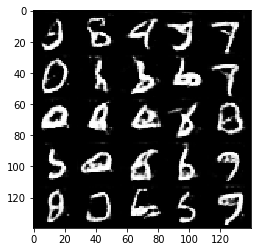

Epoch 2/2... Discriminator Loss: 1.3065... Generator Loss: 0.8883
Epoch 2/2... Discriminator Loss: 1.3407... Generator Loss: 0.8899
Epoch 2/2... Discriminator Loss: 1.2344... Generator Loss: 0.9135
Epoch 2/2... Discriminator Loss: 1.3757... Generator Loss: 0.8782
Epoch 2/2... Discriminator Loss: 1.2743... Generator Loss: 0.8187
Epoch 2/2... Discriminator Loss: 1.2829... Generator Loss: 0.9345
Epoch 2/2... Discriminator Loss: 1.3660... Generator Loss: 1.1728
Epoch 2/2... Discriminator Loss: 1.3032... Generator Loss: 0.7562
Epoch 2/2... Discriminator Loss: 1.3788... Generator Loss: 0.8437
Epoch 2/2... Discriminator Loss: 1.2620... Generator Loss: 0.8599


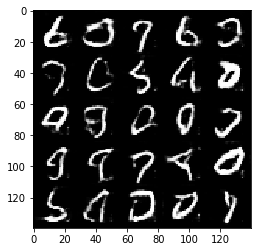

Epoch 2/2... Discriminator Loss: 1.2959... Generator Loss: 0.8127
Epoch 2/2... Discriminator Loss: 1.2810... Generator Loss: 0.8460
Epoch 2/2... Discriminator Loss: 1.3657... Generator Loss: 0.6157
Epoch 2/2... Discriminator Loss: 1.2018... Generator Loss: 1.0014
Epoch 2/2... Discriminator Loss: 1.2660... Generator Loss: 0.9451
Epoch 2/2... Discriminator Loss: 1.3041... Generator Loss: 0.8870
Epoch 2/2... Discriminator Loss: 1.3301... Generator Loss: 0.7087
Epoch 2/2... Discriminator Loss: 1.2627... Generator Loss: 0.8929
Epoch 2/2... Discriminator Loss: 1.3238... Generator Loss: 0.8199
Epoch 2/2... Discriminator Loss: 1.3403... Generator Loss: 0.8020


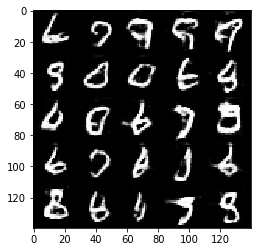

Epoch 2/2... Discriminator Loss: 1.3479... Generator Loss: 0.8119
Epoch 2/2... Discriminator Loss: 1.2602... Generator Loss: 0.8773
Epoch 2/2... Discriminator Loss: 1.3280... Generator Loss: 0.7972
Epoch 2/2... Discriminator Loss: 1.2853... Generator Loss: 0.9999
Epoch 2/2... Discriminator Loss: 1.3528... Generator Loss: 0.8584
Epoch 2/2... Discriminator Loss: 1.2417... Generator Loss: 0.9587
Epoch 2/2... Discriminator Loss: 1.3087... Generator Loss: 0.8729
Epoch 2/2... Discriminator Loss: 1.3517... Generator Loss: 0.9296
Epoch 2/2... Discriminator Loss: 1.3917... Generator Loss: 0.8854
Epoch 2/2... Discriminator Loss: 1.3049... Generator Loss: 0.8801


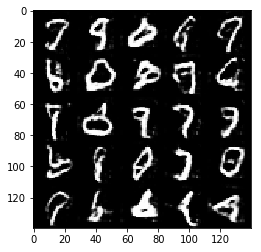

Epoch 2/2... Discriminator Loss: 1.3289... Generator Loss: 0.9965
Epoch 2/2... Discriminator Loss: 1.3594... Generator Loss: 0.8326
Epoch 2/2... Discriminator Loss: 1.3070... Generator Loss: 0.8773
Epoch 2/2... Discriminator Loss: 1.3082... Generator Loss: 0.8704
Epoch 2/2... Discriminator Loss: 1.2472... Generator Loss: 0.9151
Epoch 2/2... Discriminator Loss: 1.3249... Generator Loss: 0.8352
Epoch 2/2... Discriminator Loss: 1.2903... Generator Loss: 0.8716
Epoch 2/2... Discriminator Loss: 1.3211... Generator Loss: 0.8331
Epoch 2/2... Discriminator Loss: 1.3005... Generator Loss: 0.7539
Epoch 2/2... Discriminator Loss: 1.2655... Generator Loss: 0.8967


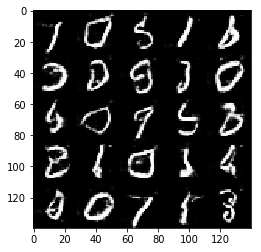

Epoch 2/2... Discriminator Loss: 1.2926... Generator Loss: 0.8692
Epoch 2/2... Discriminator Loss: 1.2873... Generator Loss: 0.8403
Epoch 2/2... Discriminator Loss: 1.3125... Generator Loss: 0.9538
Epoch 2/2... Discriminator Loss: 1.2074... Generator Loss: 0.8297
Epoch 2/2... Discriminator Loss: 1.3455... Generator Loss: 0.9497
Epoch 2/2... Discriminator Loss: 1.3253... Generator Loss: 0.8826
Epoch 2/2... Discriminator Loss: 1.3327... Generator Loss: 0.9116
Epoch 2/2... Discriminator Loss: 1.3498... Generator Loss: 0.9113
Epoch 2/2... Discriminator Loss: 1.3495... Generator Loss: 0.8441
Epoch 2/2... Discriminator Loss: 1.3164... Generator Loss: 0.8605


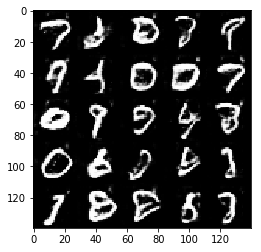

Epoch 2/2... Discriminator Loss: 1.1915... Generator Loss: 0.8943
Epoch 2/2... Discriminator Loss: 1.1982... Generator Loss: 0.7943
Epoch 2/2... Discriminator Loss: 1.2630... Generator Loss: 0.8207
Epoch 2/2... Discriminator Loss: 1.3979... Generator Loss: 0.7797
Epoch 2/2... Discriminator Loss: 1.3922... Generator Loss: 0.8547
Epoch 2/2... Discriminator Loss: 1.3559... Generator Loss: 0.7972
Epoch 2/2... Discriminator Loss: 1.2286... Generator Loss: 1.0481
Epoch 2/2... Discriminator Loss: 1.2638... Generator Loss: 0.9364
Epoch 2/2... Discriminator Loss: 1.3058... Generator Loss: 0.7760
Epoch 2/2... Discriminator Loss: 1.3312... Generator Loss: 0.8581


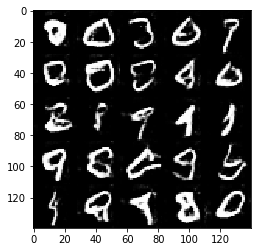

Epoch 2/2... Discriminator Loss: 1.3418... Generator Loss: 0.9446
Epoch 2/2... Discriminator Loss: 1.3241... Generator Loss: 0.8714
Epoch 2/2... Discriminator Loss: 1.3311... Generator Loss: 0.7635
Epoch 2/2... Discriminator Loss: 1.2637... Generator Loss: 0.8885
Epoch 2/2... Discriminator Loss: 1.2982... Generator Loss: 0.8579
Epoch 2/2... Discriminator Loss: 1.3508... Generator Loss: 0.8790
Epoch 2/2... Discriminator Loss: 1.3424... Generator Loss: 0.9002
Epoch 2/2... Discriminator Loss: 1.2571... Generator Loss: 0.8329
Epoch 2/2... Discriminator Loss: 1.3467... Generator Loss: 0.8709
Epoch 2/2... Discriminator Loss: 1.2097... Generator Loss: 0.9437


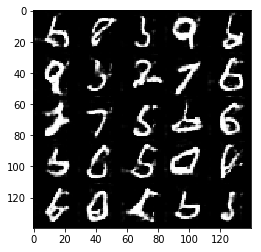

Epoch 2/2... Discriminator Loss: 1.2495... Generator Loss: 0.9524
Epoch 2/2... Discriminator Loss: 1.3430... Generator Loss: 0.8006
Epoch 2/2... Discriminator Loss: 1.2594... Generator Loss: 0.9502
Epoch 2/2... Discriminator Loss: 1.3388... Generator Loss: 0.8523
Epoch 2/2... Discriminator Loss: 1.3692... Generator Loss: 0.8348


In [22]:
batch_size  = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.3

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.2683... Generator Loss: 1.0213
Epoch 1/1... Discriminator Loss: 0.9788... Generator Loss: 1.4933
Epoch 1/1... Discriminator Loss: 0.7330... Generator Loss: 1.5146
Epoch 1/1... Discriminator Loss: 0.4917... Generator Loss: 2.6349
Epoch 1/1... Discriminator Loss: 0.4921... Generator Loss: 2.7169
Epoch 1/1... Discriminator Loss: 0.4266... Generator Loss: 3.0396
Epoch 1/1... Discriminator Loss: 0.4620... Generator Loss: 2.7353
Epoch 1/1... Discriminator Loss: 0.4182... Generator Loss: 3.2990
Epoch 1/1... Discriminator Loss: 0.4259... Generator Loss: 3.7115
Epoch 1/1... Discriminator Loss: 1.1160... Generator Loss: 2.2721


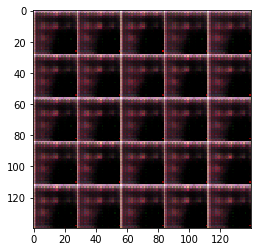

Epoch 1/1... Discriminator Loss: 0.6643... Generator Loss: 1.9654
Epoch 1/1... Discriminator Loss: 1.0264... Generator Loss: 1.0066
Epoch 1/1... Discriminator Loss: 1.6883... Generator Loss: 0.3496
Epoch 1/1... Discriminator Loss: 1.6068... Generator Loss: 0.3757
Epoch 1/1... Discriminator Loss: 0.9572... Generator Loss: 1.2202
Epoch 1/1... Discriminator Loss: 1.1082... Generator Loss: 1.2556
Epoch 1/1... Discriminator Loss: 1.1611... Generator Loss: 1.8815
Epoch 1/1... Discriminator Loss: 1.1049... Generator Loss: 0.8089
Epoch 1/1... Discriminator Loss: 0.9439... Generator Loss: 1.8617
Epoch 1/1... Discriminator Loss: 0.8584... Generator Loss: 2.0881


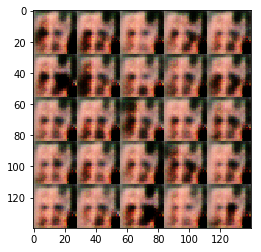

Epoch 1/1... Discriminator Loss: 1.2115... Generator Loss: 0.6036
Epoch 1/1... Discriminator Loss: 0.8785... Generator Loss: 1.4741
Epoch 1/1... Discriminator Loss: 0.8618... Generator Loss: 1.2281
Epoch 1/1... Discriminator Loss: 1.3066... Generator Loss: 2.8534
Epoch 1/1... Discriminator Loss: 0.8238... Generator Loss: 1.1380
Epoch 1/1... Discriminator Loss: 0.6323... Generator Loss: 1.8570
Epoch 1/1... Discriminator Loss: 0.6717... Generator Loss: 1.7587
Epoch 1/1... Discriminator Loss: 0.6482... Generator Loss: 2.1833
Epoch 1/1... Discriminator Loss: 0.6141... Generator Loss: 2.2968
Epoch 1/1... Discriminator Loss: 1.3022... Generator Loss: 0.5702


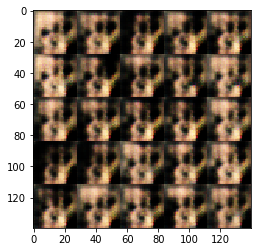

Epoch 1/1... Discriminator Loss: 0.8338... Generator Loss: 1.7001
Epoch 1/1... Discriminator Loss: 0.9356... Generator Loss: 1.0226
Epoch 1/1... Discriminator Loss: 1.1817... Generator Loss: 2.2923
Epoch 1/1... Discriminator Loss: 1.4237... Generator Loss: 3.5796
Epoch 1/1... Discriminator Loss: 0.8321... Generator Loss: 1.2533
Epoch 1/1... Discriminator Loss: 0.8277... Generator Loss: 1.3696
Epoch 1/1... Discriminator Loss: 0.8717... Generator Loss: 1.1036
Epoch 1/1... Discriminator Loss: 0.7885... Generator Loss: 2.5401
Epoch 1/1... Discriminator Loss: 0.6715... Generator Loss: 1.7178
Epoch 1/1... Discriminator Loss: 0.8975... Generator Loss: 1.1560


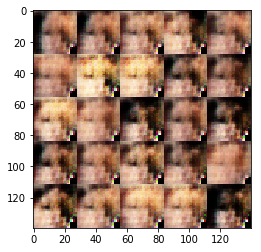

Epoch 1/1... Discriminator Loss: 0.9521... Generator Loss: 1.0386
Epoch 1/1... Discriminator Loss: 0.6816... Generator Loss: 2.2359
Epoch 1/1... Discriminator Loss: 0.6929... Generator Loss: 1.9817
Epoch 1/1... Discriminator Loss: 0.9332... Generator Loss: 1.0355
Epoch 1/1... Discriminator Loss: 0.6312... Generator Loss: 1.8412
Epoch 1/1... Discriminator Loss: 0.6574... Generator Loss: 1.9159
Epoch 1/1... Discriminator Loss: 2.2002... Generator Loss: 1.7926
Epoch 1/1... Discriminator Loss: 0.8872... Generator Loss: 1.4281
Epoch 1/1... Discriminator Loss: 0.8688... Generator Loss: 1.1807
Epoch 1/1... Discriminator Loss: 1.1637... Generator Loss: 2.1066


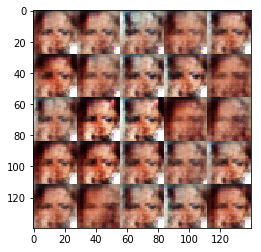

Epoch 1/1... Discriminator Loss: 1.0552... Generator Loss: 1.0744
Epoch 1/1... Discriminator Loss: 1.1273... Generator Loss: 1.1788
Epoch 1/1... Discriminator Loss: 1.6632... Generator Loss: 0.4144
Epoch 1/1... Discriminator Loss: 1.3502... Generator Loss: 0.8422
Epoch 1/1... Discriminator Loss: 1.6835... Generator Loss: 1.5200
Epoch 1/1... Discriminator Loss: 1.2877... Generator Loss: 1.1508
Epoch 1/1... Discriminator Loss: 1.1886... Generator Loss: 0.8680
Epoch 1/1... Discriminator Loss: 1.2815... Generator Loss: 0.8056
Epoch 1/1... Discriminator Loss: 1.0545... Generator Loss: 1.1719
Epoch 1/1... Discriminator Loss: 1.4339... Generator Loss: 1.3220


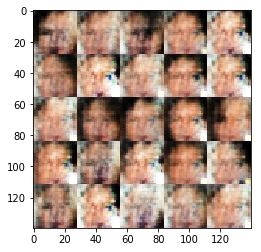

Epoch 1/1... Discriminator Loss: 1.1218... Generator Loss: 1.3703
Epoch 1/1... Discriminator Loss: 1.3793... Generator Loss: 0.7701
Epoch 1/1... Discriminator Loss: 1.2040... Generator Loss: 1.2547
Epoch 1/1... Discriminator Loss: 1.3151... Generator Loss: 1.2563
Epoch 1/1... Discriminator Loss: 1.1941... Generator Loss: 0.9648
Epoch 1/1... Discriminator Loss: 1.2580... Generator Loss: 1.4320
Epoch 1/1... Discriminator Loss: 1.2445... Generator Loss: 1.1101
Epoch 1/1... Discriminator Loss: 1.2619... Generator Loss: 0.9628
Epoch 1/1... Discriminator Loss: 1.1144... Generator Loss: 0.8493
Epoch 1/1... Discriminator Loss: 1.1830... Generator Loss: 0.8038


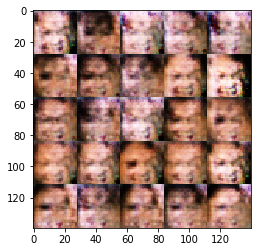

Epoch 1/1... Discriminator Loss: 1.1951... Generator Loss: 0.7847
Epoch 1/1... Discriminator Loss: 1.1146... Generator Loss: 1.0992
Epoch 1/1... Discriminator Loss: 1.2680... Generator Loss: 0.7693
Epoch 1/1... Discriminator Loss: 1.3773... Generator Loss: 0.9259
Epoch 1/1... Discriminator Loss: 1.3684... Generator Loss: 1.2406
Epoch 1/1... Discriminator Loss: 1.0213... Generator Loss: 1.1948
Epoch 1/1... Discriminator Loss: 1.1684... Generator Loss: 1.3839
Epoch 1/1... Discriminator Loss: 1.0955... Generator Loss: 1.4486
Epoch 1/1... Discriminator Loss: 1.1727... Generator Loss: 1.1093
Epoch 1/1... Discriminator Loss: 1.1272... Generator Loss: 0.9876


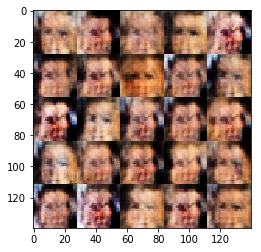

Epoch 1/1... Discriminator Loss: 1.1254... Generator Loss: 0.8546
Epoch 1/1... Discriminator Loss: 1.3376... Generator Loss: 0.9906
Epoch 1/1... Discriminator Loss: 1.0847... Generator Loss: 1.0690
Epoch 1/1... Discriminator Loss: 1.3714... Generator Loss: 1.2730
Epoch 1/1... Discriminator Loss: 1.1822... Generator Loss: 0.8905
Epoch 1/1... Discriminator Loss: 1.2191... Generator Loss: 1.2635
Epoch 1/1... Discriminator Loss: 1.1225... Generator Loss: 1.0081
Epoch 1/1... Discriminator Loss: 1.2108... Generator Loss: 0.7520
Epoch 1/1... Discriminator Loss: 1.2249... Generator Loss: 1.0325
Epoch 1/1... Discriminator Loss: 1.1910... Generator Loss: 0.9120


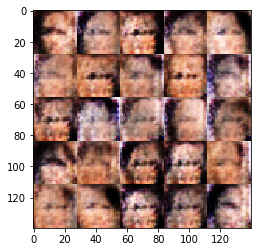

Epoch 1/1... Discriminator Loss: 1.3113... Generator Loss: 1.0313
Epoch 1/1... Discriminator Loss: 1.2818... Generator Loss: 1.4614
Epoch 1/1... Discriminator Loss: 1.1911... Generator Loss: 0.8248
Epoch 1/1... Discriminator Loss: 1.2281... Generator Loss: 0.7677
Epoch 1/1... Discriminator Loss: 1.2865... Generator Loss: 0.8734
Epoch 1/1... Discriminator Loss: 1.2512... Generator Loss: 0.9175
Epoch 1/1... Discriminator Loss: 1.1524... Generator Loss: 1.1033
Epoch 1/1... Discriminator Loss: 1.1857... Generator Loss: 0.9114
Epoch 1/1... Discriminator Loss: 1.4219... Generator Loss: 1.1092
Epoch 1/1... Discriminator Loss: 1.6604... Generator Loss: 0.7601


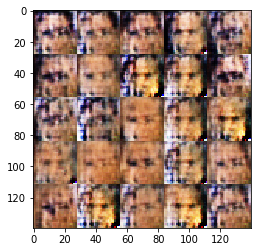

Epoch 1/1... Discriminator Loss: 1.2745... Generator Loss: 0.8571
Epoch 1/1... Discriminator Loss: 1.1762... Generator Loss: 1.0713
Epoch 1/1... Discriminator Loss: 1.2808... Generator Loss: 0.7851
Epoch 1/1... Discriminator Loss: 1.3348... Generator Loss: 0.7415
Epoch 1/1... Discriminator Loss: 1.1993... Generator Loss: 1.1328
Epoch 1/1... Discriminator Loss: 1.1418... Generator Loss: 0.9784
Epoch 1/1... Discriminator Loss: 1.2343... Generator Loss: 0.7953
Epoch 1/1... Discriminator Loss: 1.1993... Generator Loss: 1.1509
Epoch 1/1... Discriminator Loss: 1.0816... Generator Loss: 1.0829
Epoch 1/1... Discriminator Loss: 1.2544... Generator Loss: 1.0156


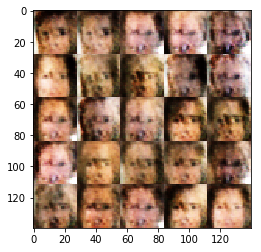

Epoch 1/1... Discriminator Loss: 1.2413... Generator Loss: 1.3300
Epoch 1/1... Discriminator Loss: 1.3544... Generator Loss: 0.7670
Epoch 1/1... Discriminator Loss: 1.2307... Generator Loss: 0.9746
Epoch 1/1... Discriminator Loss: 1.1845... Generator Loss: 1.2812
Epoch 1/1... Discriminator Loss: 1.4378... Generator Loss: 1.5042
Epoch 1/1... Discriminator Loss: 1.1638... Generator Loss: 1.0389
Epoch 1/1... Discriminator Loss: 1.2085... Generator Loss: 0.8615
Epoch 1/1... Discriminator Loss: 1.2228... Generator Loss: 0.8428
Epoch 1/1... Discriminator Loss: 1.3277... Generator Loss: 1.0617
Epoch 1/1... Discriminator Loss: 1.2145... Generator Loss: 1.0905


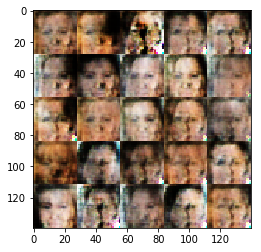

Epoch 1/1... Discriminator Loss: 1.1281... Generator Loss: 0.8295
Epoch 1/1... Discriminator Loss: 1.0738... Generator Loss: 0.9616
Epoch 1/1... Discriminator Loss: 1.1532... Generator Loss: 1.0263
Epoch 1/1... Discriminator Loss: 1.3133... Generator Loss: 0.9892
Epoch 1/1... Discriminator Loss: 1.2655... Generator Loss: 0.8374
Epoch 1/1... Discriminator Loss: 1.1429... Generator Loss: 0.9735
Epoch 1/1... Discriminator Loss: 1.1414... Generator Loss: 0.8662
Epoch 1/1... Discriminator Loss: 1.2599... Generator Loss: 0.9070
Epoch 1/1... Discriminator Loss: 1.2691... Generator Loss: 0.8571
Epoch 1/1... Discriminator Loss: 1.2753... Generator Loss: 0.9697


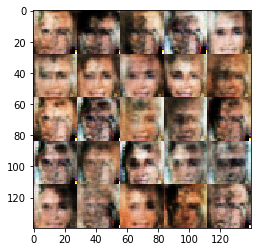

Epoch 1/1... Discriminator Loss: 1.1310... Generator Loss: 0.9255
Epoch 1/1... Discriminator Loss: 1.2457... Generator Loss: 0.9174
Epoch 1/1... Discriminator Loss: 1.2432... Generator Loss: 0.9172
Epoch 1/1... Discriminator Loss: 1.3488... Generator Loss: 0.8854
Epoch 1/1... Discriminator Loss: 1.3376... Generator Loss: 0.9847
Epoch 1/1... Discriminator Loss: 1.2992... Generator Loss: 0.8755
Epoch 1/1... Discriminator Loss: 1.3395... Generator Loss: 0.9068
Epoch 1/1... Discriminator Loss: 1.1654... Generator Loss: 1.1077
Epoch 1/1... Discriminator Loss: 1.4604... Generator Loss: 0.9985
Epoch 1/1... Discriminator Loss: 1.2504... Generator Loss: 0.9908


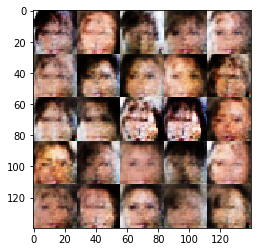

Epoch 1/1... Discriminator Loss: 1.2752... Generator Loss: 1.5101
Epoch 1/1... Discriminator Loss: 1.1258... Generator Loss: 1.1374
Epoch 1/1... Discriminator Loss: 1.3700... Generator Loss: 1.1055
Epoch 1/1... Discriminator Loss: 1.1814... Generator Loss: 1.1305
Epoch 1/1... Discriminator Loss: 1.1960... Generator Loss: 1.2505
Epoch 1/1... Discriminator Loss: 1.0757... Generator Loss: 0.9628
Epoch 1/1... Discriminator Loss: 1.2255... Generator Loss: 1.2391
Epoch 1/1... Discriminator Loss: 1.2286... Generator Loss: 1.1346
Epoch 1/1... Discriminator Loss: 1.3418... Generator Loss: 1.0349
Epoch 1/1... Discriminator Loss: 1.2995... Generator Loss: 0.9944


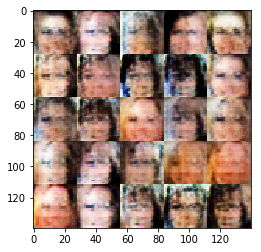

Epoch 1/1... Discriminator Loss: 1.2785... Generator Loss: 0.7782
Epoch 1/1... Discriminator Loss: 1.4021... Generator Loss: 0.7879
Epoch 1/1... Discriminator Loss: 1.1670... Generator Loss: 0.8531
Epoch 1/1... Discriminator Loss: 1.2377... Generator Loss: 1.0897
Epoch 1/1... Discriminator Loss: 1.2076... Generator Loss: 0.8084
Epoch 1/1... Discriminator Loss: 1.3304... Generator Loss: 0.6605
Epoch 1/1... Discriminator Loss: 1.2626... Generator Loss: 0.9373
Epoch 1/1... Discriminator Loss: 1.3151... Generator Loss: 0.8862
Epoch 1/1... Discriminator Loss: 1.2082... Generator Loss: 0.9839
Epoch 1/1... Discriminator Loss: 1.3730... Generator Loss: 1.1702


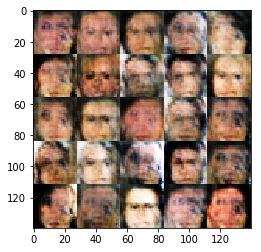

Epoch 1/1... Discriminator Loss: 1.2607... Generator Loss: 0.7528
Epoch 1/1... Discriminator Loss: 1.1828... Generator Loss: 0.9591
Epoch 1/1... Discriminator Loss: 1.4330... Generator Loss: 1.3807
Epoch 1/1... Discriminator Loss: 1.3702... Generator Loss: 0.7587
Epoch 1/1... Discriminator Loss: 1.3506... Generator Loss: 0.6788
Epoch 1/1... Discriminator Loss: 1.3435... Generator Loss: 0.8432
Epoch 1/1... Discriminator Loss: 1.2849... Generator Loss: 0.8917
Epoch 1/1... Discriminator Loss: 1.2059... Generator Loss: 1.1446
Epoch 1/1... Discriminator Loss: 1.2614... Generator Loss: 0.7919
Epoch 1/1... Discriminator Loss: 1.1880... Generator Loss: 1.0211


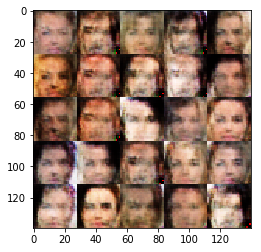

Epoch 1/1... Discriminator Loss: 1.2431... Generator Loss: 0.7821
Epoch 1/1... Discriminator Loss: 1.2630... Generator Loss: 0.8757
Epoch 1/1... Discriminator Loss: 1.3489... Generator Loss: 0.7953
Epoch 1/1... Discriminator Loss: 1.3844... Generator Loss: 0.6994
Epoch 1/1... Discriminator Loss: 1.2118... Generator Loss: 1.0943
Epoch 1/1... Discriminator Loss: 1.3906... Generator Loss: 1.2672
Epoch 1/1... Discriminator Loss: 1.1893... Generator Loss: 0.9429
Epoch 1/1... Discriminator Loss: 1.2650... Generator Loss: 0.8555
Epoch 1/1... Discriminator Loss: 1.2642... Generator Loss: 0.8578
Epoch 1/1... Discriminator Loss: 1.0856... Generator Loss: 0.8560


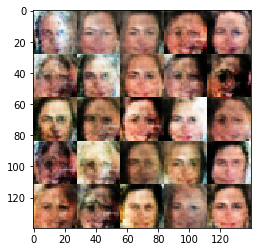

Epoch 1/1... Discriminator Loss: 1.3393... Generator Loss: 0.9438
Epoch 1/1... Discriminator Loss: 1.2641... Generator Loss: 0.8483
Epoch 1/1... Discriminator Loss: 1.1666... Generator Loss: 0.8129
Epoch 1/1... Discriminator Loss: 1.4835... Generator Loss: 0.8868
Epoch 1/1... Discriminator Loss: 1.1583... Generator Loss: 1.0027
Epoch 1/1... Discriminator Loss: 1.3541... Generator Loss: 0.9825
Epoch 1/1... Discriminator Loss: 1.5085... Generator Loss: 1.0792
Epoch 1/1... Discriminator Loss: 1.0034... Generator Loss: 1.2220
Epoch 1/1... Discriminator Loss: 1.3234... Generator Loss: 1.3630
Epoch 1/1... Discriminator Loss: 1.3882... Generator Loss: 1.2238


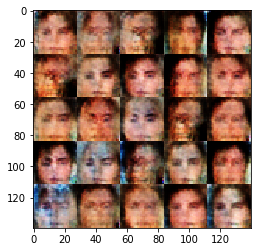

Epoch 1/1... Discriminator Loss: 1.3301... Generator Loss: 1.0847
Epoch 1/1... Discriminator Loss: 1.1936... Generator Loss: 1.1513
Epoch 1/1... Discriminator Loss: 1.2864... Generator Loss: 1.1092
Epoch 1/1... Discriminator Loss: 1.2525... Generator Loss: 0.9124
Epoch 1/1... Discriminator Loss: 1.2360... Generator Loss: 1.0410
Epoch 1/1... Discriminator Loss: 1.2631... Generator Loss: 1.2009
Epoch 1/1... Discriminator Loss: 1.2579... Generator Loss: 0.9595
Epoch 1/1... Discriminator Loss: 1.2446... Generator Loss: 0.7977
Epoch 1/1... Discriminator Loss: 1.2585... Generator Loss: 0.9526
Epoch 1/1... Discriminator Loss: 1.3092... Generator Loss: 0.8429


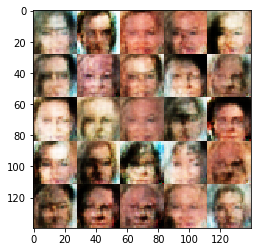

Epoch 1/1... Discriminator Loss: 1.3352... Generator Loss: 0.8958
Epoch 1/1... Discriminator Loss: 1.1733... Generator Loss: 0.8569
Epoch 1/1... Discriminator Loss: 1.2305... Generator Loss: 1.0572
Epoch 1/1... Discriminator Loss: 1.1704... Generator Loss: 0.9462
Epoch 1/1... Discriminator Loss: 1.3351... Generator Loss: 0.7362
Epoch 1/1... Discriminator Loss: 1.2484... Generator Loss: 0.8364
Epoch 1/1... Discriminator Loss: 1.2763... Generator Loss: 0.7536
Epoch 1/1... Discriminator Loss: 1.2693... Generator Loss: 0.9091
Epoch 1/1... Discriminator Loss: 1.2490... Generator Loss: 0.8600
Epoch 1/1... Discriminator Loss: 1.2702... Generator Loss: 1.0091


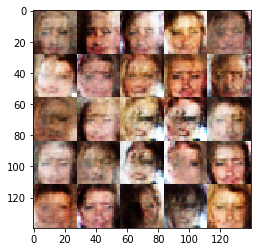

Epoch 1/1... Discriminator Loss: 1.3072... Generator Loss: 0.9140
Epoch 1/1... Discriminator Loss: 1.2369... Generator Loss: 0.9921
Epoch 1/1... Discriminator Loss: 1.5633... Generator Loss: 0.4876
Epoch 1/1... Discriminator Loss: 1.2273... Generator Loss: 0.9666
Epoch 1/1... Discriminator Loss: 1.2436... Generator Loss: 0.8366
Epoch 1/1... Discriminator Loss: 1.2330... Generator Loss: 0.8917
Epoch 1/1... Discriminator Loss: 1.2032... Generator Loss: 0.8845
Epoch 1/1... Discriminator Loss: 1.2417... Generator Loss: 0.6739
Epoch 1/1... Discriminator Loss: 1.1950... Generator Loss: 0.9525
Epoch 1/1... Discriminator Loss: 1.0986... Generator Loss: 1.1970


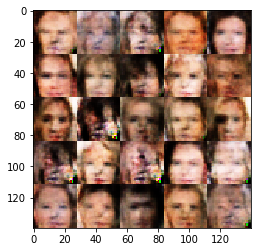

Epoch 1/1... Discriminator Loss: 1.3312... Generator Loss: 1.0279
Epoch 1/1... Discriminator Loss: 1.2772... Generator Loss: 1.1396
Epoch 1/1... Discriminator Loss: 1.3058... Generator Loss: 1.4041
Epoch 1/1... Discriminator Loss: 1.2491... Generator Loss: 0.9264
Epoch 1/1... Discriminator Loss: 1.2468... Generator Loss: 1.0447
Epoch 1/1... Discriminator Loss: 1.2679... Generator Loss: 0.8414
Epoch 1/1... Discriminator Loss: 1.3348... Generator Loss: 1.1295
Epoch 1/1... Discriminator Loss: 1.5099... Generator Loss: 1.1213
Epoch 1/1... Discriminator Loss: 1.3120... Generator Loss: 0.7152
Epoch 1/1... Discriminator Loss: 1.2838... Generator Loss: 0.8987


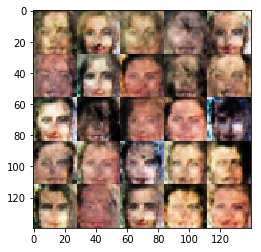

Epoch 1/1... Discriminator Loss: 1.2996... Generator Loss: 0.9029
Epoch 1/1... Discriminator Loss: 1.3094... Generator Loss: 0.9270
Epoch 1/1... Discriminator Loss: 1.3080... Generator Loss: 0.9700
Epoch 1/1... Discriminator Loss: 1.2451... Generator Loss: 0.8875
Epoch 1/1... Discriminator Loss: 1.3683... Generator Loss: 0.7242
Epoch 1/1... Discriminator Loss: 1.2538... Generator Loss: 0.8653
Epoch 1/1... Discriminator Loss: 1.4469... Generator Loss: 0.6186
Epoch 1/1... Discriminator Loss: 1.3185... Generator Loss: 0.9674
Epoch 1/1... Discriminator Loss: 1.2386... Generator Loss: 0.8504
Epoch 1/1... Discriminator Loss: 1.3872... Generator Loss: 0.7958


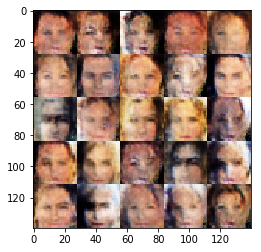

Epoch 1/1... Discriminator Loss: 1.3912... Generator Loss: 0.9757
Epoch 1/1... Discriminator Loss: 1.2483... Generator Loss: 0.7735
Epoch 1/1... Discriminator Loss: 1.2580... Generator Loss: 0.8455
Epoch 1/1... Discriminator Loss: 1.3037... Generator Loss: 0.6915
Epoch 1/1... Discriminator Loss: 1.2992... Generator Loss: 0.9047
Epoch 1/1... Discriminator Loss: 1.3042... Generator Loss: 0.8932
Epoch 1/1... Discriminator Loss: 1.1857... Generator Loss: 0.8735
Epoch 1/1... Discriminator Loss: 1.1877... Generator Loss: 0.9462
Epoch 1/1... Discriminator Loss: 1.4488... Generator Loss: 0.7909
Epoch 1/1... Discriminator Loss: 1.1514... Generator Loss: 0.9390


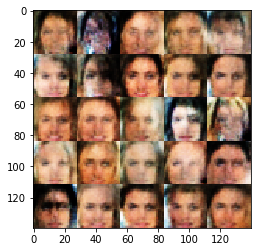

Epoch 1/1... Discriminator Loss: 1.2586... Generator Loss: 0.8369
Epoch 1/1... Discriminator Loss: 1.2376... Generator Loss: 1.2178
Epoch 1/1... Discriminator Loss: 1.3076... Generator Loss: 1.0661
Epoch 1/1... Discriminator Loss: 1.2306... Generator Loss: 0.9365
Epoch 1/1... Discriminator Loss: 1.4900... Generator Loss: 0.6634
Epoch 1/1... Discriminator Loss: 1.6348... Generator Loss: 1.4326
Epoch 1/1... Discriminator Loss: 1.3357... Generator Loss: 1.0934
Epoch 1/1... Discriminator Loss: 1.2787... Generator Loss: 0.9677
Epoch 1/1... Discriminator Loss: 1.3221... Generator Loss: 1.0530
Epoch 1/1... Discriminator Loss: 1.2811... Generator Loss: 0.7603


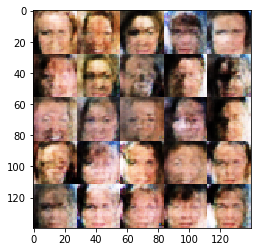

Epoch 1/1... Discriminator Loss: 1.3395... Generator Loss: 0.8043
Epoch 1/1... Discriminator Loss: 1.2564... Generator Loss: 0.8951
Epoch 1/1... Discriminator Loss: 1.1943... Generator Loss: 0.9662
Epoch 1/1... Discriminator Loss: 1.2976... Generator Loss: 0.7802
Epoch 1/1... Discriminator Loss: 1.4186... Generator Loss: 0.5855
Epoch 1/1... Discriminator Loss: 1.2762... Generator Loss: 0.9318
Epoch 1/1... Discriminator Loss: 1.3367... Generator Loss: 0.8399
Epoch 1/1... Discriminator Loss: 1.3083... Generator Loss: 1.0916
Epoch 1/1... Discriminator Loss: 1.2813... Generator Loss: 1.0569
Epoch 1/1... Discriminator Loss: 1.2847... Generator Loss: 0.8853


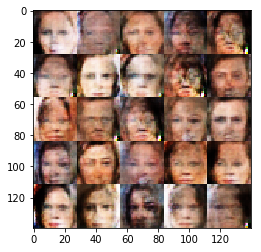

Epoch 1/1... Discriminator Loss: 1.2112... Generator Loss: 0.7730
Epoch 1/1... Discriminator Loss: 1.4504... Generator Loss: 1.1949
Epoch 1/1... Discriminator Loss: 1.2541... Generator Loss: 0.8970
Epoch 1/1... Discriminator Loss: 1.2841... Generator Loss: 0.8706
Epoch 1/1... Discriminator Loss: 1.2945... Generator Loss: 0.8661
Epoch 1/1... Discriminator Loss: 1.2741... Generator Loss: 0.7938
Epoch 1/1... Discriminator Loss: 1.3611... Generator Loss: 1.2513
Epoch 1/1... Discriminator Loss: 1.3056... Generator Loss: 0.8531
Epoch 1/1... Discriminator Loss: 1.3453... Generator Loss: 0.8900
Epoch 1/1... Discriminator Loss: 1.3067... Generator Loss: 0.9951


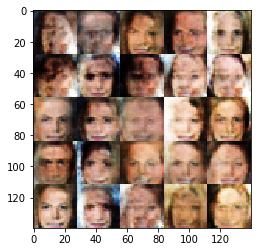

Epoch 1/1... Discriminator Loss: 1.2304... Generator Loss: 0.8603
Epoch 1/1... Discriminator Loss: 1.2241... Generator Loss: 0.9784
Epoch 1/1... Discriminator Loss: 1.2651... Generator Loss: 0.8446
Epoch 1/1... Discriminator Loss: 1.2077... Generator Loss: 0.9170
Epoch 1/1... Discriminator Loss: 1.1794... Generator Loss: 0.8926
Epoch 1/1... Discriminator Loss: 1.2653... Generator Loss: 0.9735
Epoch 1/1... Discriminator Loss: 1.1435... Generator Loss: 1.0280
Epoch 1/1... Discriminator Loss: 1.1990... Generator Loss: 0.8804
Epoch 1/1... Discriminator Loss: 1.1992... Generator Loss: 0.9648
Epoch 1/1... Discriminator Loss: 1.3085... Generator Loss: 0.9971


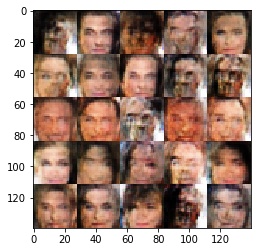

Epoch 1/1... Discriminator Loss: 1.2743... Generator Loss: 0.6822
Epoch 1/1... Discriminator Loss: 1.3075... Generator Loss: 0.7235
Epoch 1/1... Discriminator Loss: 1.2864... Generator Loss: 0.8034
Epoch 1/1... Discriminator Loss: 1.2427... Generator Loss: 1.0155
Epoch 1/1... Discriminator Loss: 1.4776... Generator Loss: 1.0609
Epoch 1/1... Discriminator Loss: 1.5774... Generator Loss: 0.9081
Epoch 1/1... Discriminator Loss: 1.1824... Generator Loss: 0.8760
Epoch 1/1... Discriminator Loss: 1.4110... Generator Loss: 0.9036
Epoch 1/1... Discriminator Loss: 1.4478... Generator Loss: 0.9993
Epoch 1/1... Discriminator Loss: 1.4795... Generator Loss: 0.5486


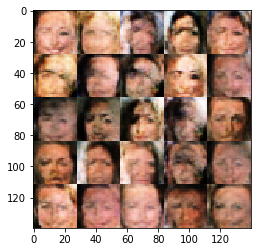

Epoch 1/1... Discriminator Loss: 1.3033... Generator Loss: 1.0102
Epoch 1/1... Discriminator Loss: 1.2786... Generator Loss: 1.0486
Epoch 1/1... Discriminator Loss: 1.3539... Generator Loss: 1.1266
Epoch 1/1... Discriminator Loss: 1.3248... Generator Loss: 0.7894
Epoch 1/1... Discriminator Loss: 1.3983... Generator Loss: 0.9964
Epoch 1/1... Discriminator Loss: 1.2361... Generator Loss: 0.9285
Epoch 1/1... Discriminator Loss: 1.2888... Generator Loss: 0.8829
Epoch 1/1... Discriminator Loss: 1.2594... Generator Loss: 0.8191
Epoch 1/1... Discriminator Loss: 1.3269... Generator Loss: 0.9370
Epoch 1/1... Discriminator Loss: 1.3263... Generator Loss: 0.7659


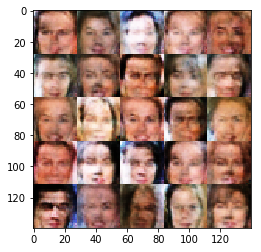

Epoch 1/1... Discriminator Loss: 1.2369... Generator Loss: 0.7613
Epoch 1/1... Discriminator Loss: 1.3052... Generator Loss: 0.8330
Epoch 1/1... Discriminator Loss: 1.2181... Generator Loss: 0.8890
Epoch 1/1... Discriminator Loss: 1.3170... Generator Loss: 0.9470
Epoch 1/1... Discriminator Loss: 1.3281... Generator Loss: 0.9204
Epoch 1/1... Discriminator Loss: 1.4401... Generator Loss: 0.9629
Epoch 1/1... Discriminator Loss: 1.3532... Generator Loss: 0.7909
Epoch 1/1... Discriminator Loss: 1.3859... Generator Loss: 0.7529
Epoch 1/1... Discriminator Loss: 1.2508... Generator Loss: 0.7052
Epoch 1/1... Discriminator Loss: 1.2662... Generator Loss: 0.9505


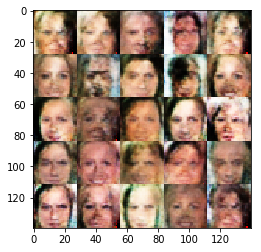

Epoch 1/1... Discriminator Loss: 1.3017... Generator Loss: 1.0078
Epoch 1/1... Discriminator Loss: 1.1253... Generator Loss: 0.9814
Epoch 1/1... Discriminator Loss: 1.2942... Generator Loss: 0.8058
Epoch 1/1... Discriminator Loss: 1.3816... Generator Loss: 0.9534
Epoch 1/1... Discriminator Loss: 1.2860... Generator Loss: 1.0055
Epoch 1/1... Discriminator Loss: 1.3617... Generator Loss: 0.8226
Epoch 1/1... Discriminator Loss: 1.2456... Generator Loss: 0.7720
Epoch 1/1... Discriminator Loss: 1.2785... Generator Loss: 0.9036
Epoch 1/1... Discriminator Loss: 1.2446... Generator Loss: 0.8930
Epoch 1/1... Discriminator Loss: 1.2119... Generator Loss: 0.8952


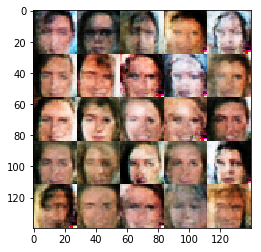

Epoch 1/1... Discriminator Loss: 1.1862... Generator Loss: 1.0164
Epoch 1/1... Discriminator Loss: 1.2567... Generator Loss: 0.7177
Epoch 1/1... Discriminator Loss: 1.5291... Generator Loss: 0.5530
Epoch 1/1... Discriminator Loss: 1.9378... Generator Loss: 0.5317
Epoch 1/1... Discriminator Loss: 1.5683... Generator Loss: 1.1429
Epoch 1/1... Discriminator Loss: 1.3732... Generator Loss: 0.7474
Epoch 1/1... Discriminator Loss: 1.5559... Generator Loss: 1.3861
Epoch 1/1... Discriminator Loss: 1.2537... Generator Loss: 0.7935
Epoch 1/1... Discriminator Loss: 1.2467... Generator Loss: 0.9061
Epoch 1/1... Discriminator Loss: 1.3166... Generator Loss: 0.7852


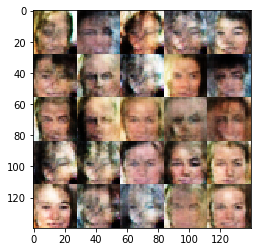

Epoch 1/1... Discriminator Loss: 1.2601... Generator Loss: 0.8552
Epoch 1/1... Discriminator Loss: 1.3010... Generator Loss: 0.8610
Epoch 1/1... Discriminator Loss: 1.3089... Generator Loss: 0.9101
Epoch 1/1... Discriminator Loss: 1.2928... Generator Loss: 0.9029
Epoch 1/1... Discriminator Loss: 1.3276... Generator Loss: 0.9099
Epoch 1/1... Discriminator Loss: 1.3621... Generator Loss: 0.7924
Epoch 1/1... Discriminator Loss: 1.3352... Generator Loss: 0.7125
Epoch 1/1... Discriminator Loss: 1.2916... Generator Loss: 1.0097
Epoch 1/1... Discriminator Loss: 1.3492... Generator Loss: 1.0461
Epoch 1/1... Discriminator Loss: 1.4312... Generator Loss: 0.8115


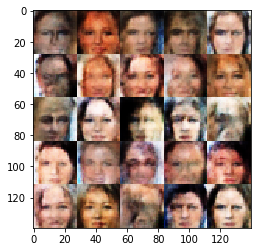

Epoch 1/1... Discriminator Loss: 1.3727... Generator Loss: 0.9216
Epoch 1/1... Discriminator Loss: 1.3184... Generator Loss: 0.7956
Epoch 1/1... Discriminator Loss: 1.2968... Generator Loss: 0.8649
Epoch 1/1... Discriminator Loss: 1.3544... Generator Loss: 0.7944
Epoch 1/1... Discriminator Loss: 1.3169... Generator Loss: 0.9676
Epoch 1/1... Discriminator Loss: 1.2485... Generator Loss: 0.8882
Epoch 1/1... Discriminator Loss: 1.4652... Generator Loss: 0.9182
Epoch 1/1... Discriminator Loss: 1.2800... Generator Loss: 0.8000
Epoch 1/1... Discriminator Loss: 1.2438... Generator Loss: 0.8154
Epoch 1/1... Discriminator Loss: 1.3410... Generator Loss: 0.7968


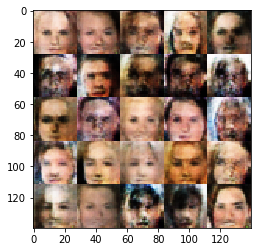

Epoch 1/1... Discriminator Loss: 1.2428... Generator Loss: 0.8143
Epoch 1/1... Discriminator Loss: 1.3021... Generator Loss: 0.9385
Epoch 1/1... Discriminator Loss: 1.2887... Generator Loss: 0.8027
Epoch 1/1... Discriminator Loss: 1.2780... Generator Loss: 0.9868
Epoch 1/1... Discriminator Loss: 1.2735... Generator Loss: 0.9150
Epoch 1/1... Discriminator Loss: 1.3524... Generator Loss: 0.8618
Epoch 1/1... Discriminator Loss: 1.3127... Generator Loss: 0.9410
Epoch 1/1... Discriminator Loss: 1.3371... Generator Loss: 0.9461
Epoch 1/1... Discriminator Loss: 1.2553... Generator Loss: 1.0080
Epoch 1/1... Discriminator Loss: 1.3450... Generator Loss: 0.8674


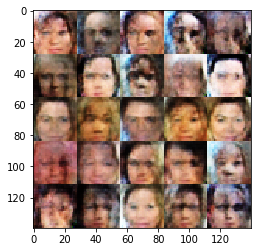

Epoch 1/1... Discriminator Loss: 1.2975... Generator Loss: 0.8246
Epoch 1/1... Discriminator Loss: 1.2881... Generator Loss: 0.8921
Epoch 1/1... Discriminator Loss: 1.2928... Generator Loss: 0.8740
Epoch 1/1... Discriminator Loss: 1.3157... Generator Loss: 0.7428
Epoch 1/1... Discriminator Loss: 1.3349... Generator Loss: 0.7824
Epoch 1/1... Discriminator Loss: 1.3130... Generator Loss: 0.8471
Epoch 1/1... Discriminator Loss: 1.2796... Generator Loss: 0.8520
Epoch 1/1... Discriminator Loss: 1.3455... Generator Loss: 0.7370
Epoch 1/1... Discriminator Loss: 1.2741... Generator Loss: 0.8086
Epoch 1/1... Discriminator Loss: 1.2794... Generator Loss: 0.8252


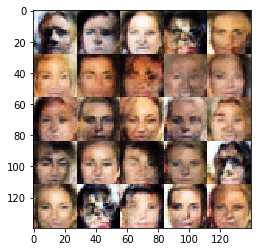

Epoch 1/1... Discriminator Loss: 1.3467... Generator Loss: 0.8557
Epoch 1/1... Discriminator Loss: 1.3098... Generator Loss: 0.8325
Epoch 1/1... Discriminator Loss: 1.2419... Generator Loss: 0.8721
Epoch 1/1... Discriminator Loss: 1.3531... Generator Loss: 0.8738
Epoch 1/1... Discriminator Loss: 1.2924... Generator Loss: 0.9085
Epoch 1/1... Discriminator Loss: 1.3785... Generator Loss: 0.8463
Epoch 1/1... Discriminator Loss: 1.4017... Generator Loss: 0.6492
Epoch 1/1... Discriminator Loss: 1.4297... Generator Loss: 0.8598
Epoch 1/1... Discriminator Loss: 1.3020... Generator Loss: 0.8731
Epoch 1/1... Discriminator Loss: 1.2777... Generator Loss: 0.8041


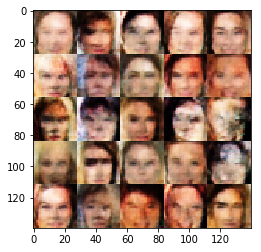

Epoch 1/1... Discriminator Loss: 1.2886... Generator Loss: 0.8239
Epoch 1/1... Discriminator Loss: 1.4070... Generator Loss: 0.7900
Epoch 1/1... Discriminator Loss: 1.3010... Generator Loss: 0.7604
Epoch 1/1... Discriminator Loss: 1.2868... Generator Loss: 0.8499
Epoch 1/1... Discriminator Loss: 1.3159... Generator Loss: 0.8240
Epoch 1/1... Discriminator Loss: 1.5245... Generator Loss: 0.7483
Epoch 1/1... Discriminator Loss: 1.3927... Generator Loss: 0.8698
Epoch 1/1... Discriminator Loss: 1.4739... Generator Loss: 0.9143
Epoch 1/1... Discriminator Loss: 1.4078... Generator Loss: 1.1080
Epoch 1/1... Discriminator Loss: 1.2954... Generator Loss: 0.7310


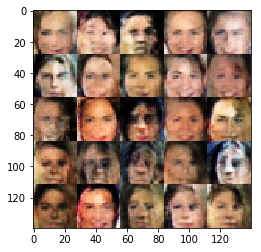

Epoch 1/1... Discriminator Loss: 1.2541... Generator Loss: 0.8322
Epoch 1/1... Discriminator Loss: 1.2755... Generator Loss: 0.9789
Epoch 1/1... Discriminator Loss: 1.4274... Generator Loss: 0.8118
Epoch 1/1... Discriminator Loss: 1.2932... Generator Loss: 0.9006
Epoch 1/1... Discriminator Loss: 1.3657... Generator Loss: 0.7814
Epoch 1/1... Discriminator Loss: 1.3196... Generator Loss: 0.7861
Epoch 1/1... Discriminator Loss: 1.3587... Generator Loss: 0.9825
Epoch 1/1... Discriminator Loss: 1.2395... Generator Loss: 0.9170
Epoch 1/1... Discriminator Loss: 1.2742... Generator Loss: 0.8659
Epoch 1/1... Discriminator Loss: 1.3786... Generator Loss: 0.7940


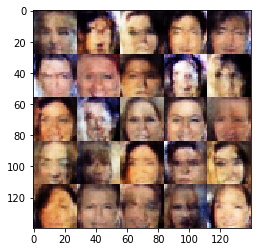

Epoch 1/1... Discriminator Loss: 1.2784... Generator Loss: 0.8410
Epoch 1/1... Discriminator Loss: 1.2970... Generator Loss: 0.8132
Epoch 1/1... Discriminator Loss: 1.3458... Generator Loss: 0.8316
Epoch 1/1... Discriminator Loss: 1.3250... Generator Loss: 0.8264
Epoch 1/1... Discriminator Loss: 1.2897... Generator Loss: 0.8395
Epoch 1/1... Discriminator Loss: 1.2411... Generator Loss: 0.9445
Epoch 1/1... Discriminator Loss: 1.3644... Generator Loss: 0.6909
Epoch 1/1... Discriminator Loss: 1.3320... Generator Loss: 0.8934
Epoch 1/1... Discriminator Loss: 1.3547... Generator Loss: 0.9272
Epoch 1/1... Discriminator Loss: 1.2892... Generator Loss: 1.0418


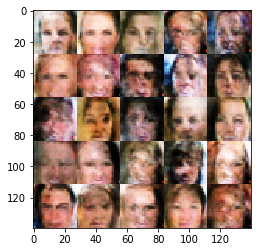

Epoch 1/1... Discriminator Loss: 1.2727... Generator Loss: 0.8744
Epoch 1/1... Discriminator Loss: 1.3809... Generator Loss: 0.8259
Epoch 1/1... Discriminator Loss: 1.3082... Generator Loss: 0.8249
Epoch 1/1... Discriminator Loss: 1.3041... Generator Loss: 0.7846
Epoch 1/1... Discriminator Loss: 1.2345... Generator Loss: 0.8050
Epoch 1/1... Discriminator Loss: 1.3090... Generator Loss: 0.8260
Epoch 1/1... Discriminator Loss: 1.3098... Generator Loss: 0.8109
Epoch 1/1... Discriminator Loss: 1.3799... Generator Loss: 0.6605
Epoch 1/1... Discriminator Loss: 1.3020... Generator Loss: 0.8863
Epoch 1/1... Discriminator Loss: 1.3469... Generator Loss: 0.7239


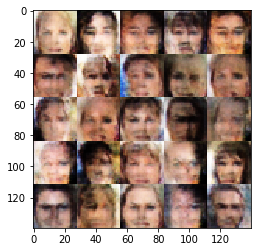

Epoch 1/1... Discriminator Loss: 1.2627... Generator Loss: 0.9120
Epoch 1/1... Discriminator Loss: 1.2880... Generator Loss: 0.9841
Epoch 1/1... Discriminator Loss: 1.3417... Generator Loss: 0.8381
Epoch 1/1... Discriminator Loss: 1.3030... Generator Loss: 0.9171
Epoch 1/1... Discriminator Loss: 1.2360... Generator Loss: 0.8824
Epoch 1/1... Discriminator Loss: 1.3412... Generator Loss: 0.9281
Epoch 1/1... Discriminator Loss: 1.2531... Generator Loss: 0.8271
Epoch 1/1... Discriminator Loss: 1.3189... Generator Loss: 1.1535
Epoch 1/1... Discriminator Loss: 1.2480... Generator Loss: 0.9125
Epoch 1/1... Discriminator Loss: 1.3287... Generator Loss: 0.9433


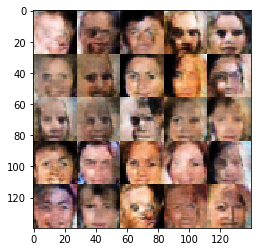

Epoch 1/1... Discriminator Loss: 1.3639... Generator Loss: 1.1083
Epoch 1/1... Discriminator Loss: 1.2212... Generator Loss: 0.8773
Epoch 1/1... Discriminator Loss: 1.3566... Generator Loss: 0.7405
Epoch 1/1... Discriminator Loss: 1.2791... Generator Loss: 0.8221
Epoch 1/1... Discriminator Loss: 1.4261... Generator Loss: 0.7229
Epoch 1/1... Discriminator Loss: 1.3552... Generator Loss: 0.9255
Epoch 1/1... Discriminator Loss: 1.3122... Generator Loss: 0.8050
Epoch 1/1... Discriminator Loss: 1.3353... Generator Loss: 0.7976
Epoch 1/1... Discriminator Loss: 1.3523... Generator Loss: 0.6903
Epoch 1/1... Discriminator Loss: 1.2981... Generator Loss: 0.9429


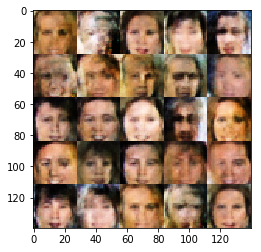

Epoch 1/1... Discriminator Loss: 1.3732... Generator Loss: 0.7546
Epoch 1/1... Discriminator Loss: 1.4164... Generator Loss: 0.8106
Epoch 1/1... Discriminator Loss: 1.3163... Generator Loss: 0.7891
Epoch 1/1... Discriminator Loss: 1.3047... Generator Loss: 0.8123
Epoch 1/1... Discriminator Loss: 1.3483... Generator Loss: 0.7718
Epoch 1/1... Discriminator Loss: 1.2942... Generator Loss: 0.7955
Epoch 1/1... Discriminator Loss: 1.3092... Generator Loss: 0.8795
Epoch 1/1... Discriminator Loss: 1.2908... Generator Loss: 0.7850
Epoch 1/1... Discriminator Loss: 1.2661... Generator Loss: 0.8934
Epoch 1/1... Discriminator Loss: 1.2993... Generator Loss: 0.8634


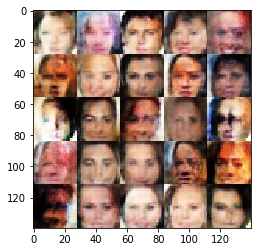

Epoch 1/1... Discriminator Loss: 1.2977... Generator Loss: 0.7318
Epoch 1/1... Discriminator Loss: 1.2943... Generator Loss: 0.9011
Epoch 1/1... Discriminator Loss: 1.2713... Generator Loss: 0.9749
Epoch 1/1... Discriminator Loss: 1.3243... Generator Loss: 0.8796
Epoch 1/1... Discriminator Loss: 1.2891... Generator Loss: 0.7978
Epoch 1/1... Discriminator Loss: 1.3054... Generator Loss: 0.7406
Epoch 1/1... Discriminator Loss: 1.2964... Generator Loss: 0.8572
Epoch 1/1... Discriminator Loss: 1.2690... Generator Loss: 0.8505
Epoch 1/1... Discriminator Loss: 1.2498... Generator Loss: 0.8232
Epoch 1/1... Discriminator Loss: 1.3338... Generator Loss: 0.7915


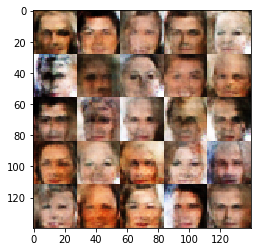

Epoch 1/1... Discriminator Loss: 1.3467... Generator Loss: 0.8956
Epoch 1/1... Discriminator Loss: 1.3201... Generator Loss: 0.9981
Epoch 1/1... Discriminator Loss: 1.2942... Generator Loss: 0.9994
Epoch 1/1... Discriminator Loss: 1.4424... Generator Loss: 0.8758
Epoch 1/1... Discriminator Loss: 1.3466... Generator Loss: 0.9247
Epoch 1/1... Discriminator Loss: 1.3194... Generator Loss: 1.0386
Epoch 1/1... Discriminator Loss: 1.2582... Generator Loss: 1.0903
Epoch 1/1... Discriminator Loss: 1.2382... Generator Loss: 0.8469
Epoch 1/1... Discriminator Loss: 1.3142... Generator Loss: 0.8242
Epoch 1/1... Discriminator Loss: 1.2379... Generator Loss: 0.8442


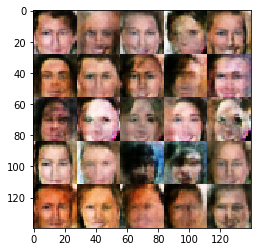

Epoch 1/1... Discriminator Loss: 1.4877... Generator Loss: 0.8092
Epoch 1/1... Discriminator Loss: 1.3396... Generator Loss: 0.8694
Epoch 1/1... Discriminator Loss: 1.3421... Generator Loss: 0.8585
Epoch 1/1... Discriminator Loss: 1.3274... Generator Loss: 0.8384
Epoch 1/1... Discriminator Loss: 1.2191... Generator Loss: 0.8018
Epoch 1/1... Discriminator Loss: 1.2880... Generator Loss: 0.9538
Epoch 1/1... Discriminator Loss: 1.3448... Generator Loss: 0.8044
Epoch 1/1... Discriminator Loss: 1.3375... Generator Loss: 0.9297
Epoch 1/1... Discriminator Loss: 1.3203... Generator Loss: 0.8617
Epoch 1/1... Discriminator Loss: 1.2752... Generator Loss: 0.7635


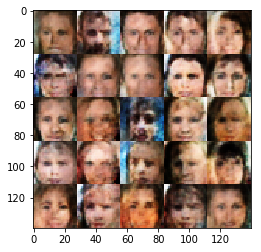

Epoch 1/1... Discriminator Loss: 1.3290... Generator Loss: 0.8215
Epoch 1/1... Discriminator Loss: 1.4074... Generator Loss: 0.6697
Epoch 1/1... Discriminator Loss: 1.2943... Generator Loss: 0.8762
Epoch 1/1... Discriminator Loss: 1.3001... Generator Loss: 0.9157
Epoch 1/1... Discriminator Loss: 1.4050... Generator Loss: 0.7375
Epoch 1/1... Discriminator Loss: 1.4251... Generator Loss: 0.7474
Epoch 1/1... Discriminator Loss: 1.3444... Generator Loss: 1.0558
Epoch 1/1... Discriminator Loss: 1.3704... Generator Loss: 0.8203
Epoch 1/1... Discriminator Loss: 1.2823... Generator Loss: 0.8117
Epoch 1/1... Discriminator Loss: 1.3246... Generator Loss: 0.8745


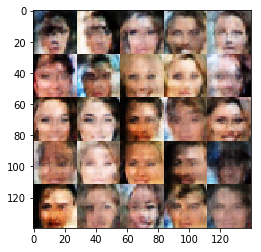

Epoch 1/1... Discriminator Loss: 1.3768... Generator Loss: 0.8933
Epoch 1/1... Discriminator Loss: 1.2965... Generator Loss: 0.9560
Epoch 1/1... Discriminator Loss: 1.3013... Generator Loss: 0.8521
Epoch 1/1... Discriminator Loss: 1.3087... Generator Loss: 0.8290
Epoch 1/1... Discriminator Loss: 1.2736... Generator Loss: 0.9529
Epoch 1/1... Discriminator Loss: 1.2776... Generator Loss: 0.8771
Epoch 1/1... Discriminator Loss: 1.2762... Generator Loss: 0.8571
Epoch 1/1... Discriminator Loss: 1.3322... Generator Loss: 0.9818
Epoch 1/1... Discriminator Loss: 1.3310... Generator Loss: 0.9152
Epoch 1/1... Discriminator Loss: 1.3375... Generator Loss: 0.7694


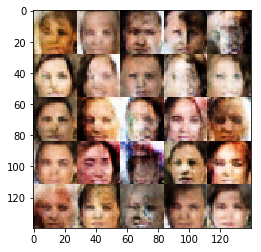

Epoch 1/1... Discriminator Loss: 1.2992... Generator Loss: 0.8036
Epoch 1/1... Discriminator Loss: 1.2918... Generator Loss: 0.8506
Epoch 1/1... Discriminator Loss: 1.3104... Generator Loss: 0.7593
Epoch 1/1... Discriminator Loss: 1.3597... Generator Loss: 0.7712
Epoch 1/1... Discriminator Loss: 1.3482... Generator Loss: 0.7898
Epoch 1/1... Discriminator Loss: 1.2879... Generator Loss: 0.7779
Epoch 1/1... Discriminator Loss: 1.3624... Generator Loss: 0.7692
Epoch 1/1... Discriminator Loss: 1.3256... Generator Loss: 0.9572
Epoch 1/1... Discriminator Loss: 1.3190... Generator Loss: 0.8225
Epoch 1/1... Discriminator Loss: 1.3505... Generator Loss: 0.7664


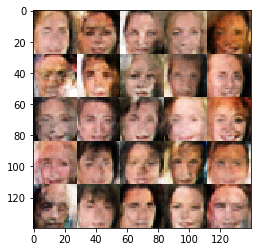

Epoch 1/1... Discriminator Loss: 1.3478... Generator Loss: 0.7846
Epoch 1/1... Discriminator Loss: 1.4462... Generator Loss: 1.0211
Epoch 1/1... Discriminator Loss: 1.3311... Generator Loss: 0.8257
Epoch 1/1... Discriminator Loss: 1.2671... Generator Loss: 0.7493
Epoch 1/1... Discriminator Loss: 1.2504... Generator Loss: 0.8893
Epoch 1/1... Discriminator Loss: 1.3670... Generator Loss: 1.0146
Epoch 1/1... Discriminator Loss: 1.3173... Generator Loss: 0.6831
Epoch 1/1... Discriminator Loss: 1.3064... Generator Loss: 0.9145
Epoch 1/1... Discriminator Loss: 1.3286... Generator Loss: 0.6536
Epoch 1/1... Discriminator Loss: 1.2635... Generator Loss: 0.9303


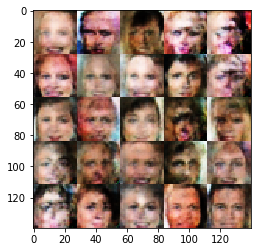

Epoch 1/1... Discriminator Loss: 1.3189... Generator Loss: 0.8568
Epoch 1/1... Discriminator Loss: 1.3530... Generator Loss: 0.8520
Epoch 1/1... Discriminator Loss: 1.4111... Generator Loss: 0.7761
Epoch 1/1... Discriminator Loss: 1.2842... Generator Loss: 0.8878
Epoch 1/1... Discriminator Loss: 1.4047... Generator Loss: 1.0464
Epoch 1/1... Discriminator Loss: 1.3323... Generator Loss: 0.8876
Epoch 1/1... Discriminator Loss: 1.3276... Generator Loss: 0.7369
Epoch 1/1... Discriminator Loss: 1.2791... Generator Loss: 0.7853
Epoch 1/1... Discriminator Loss: 1.3657... Generator Loss: 0.8967
Epoch 1/1... Discriminator Loss: 1.3573... Generator Loss: 0.7666


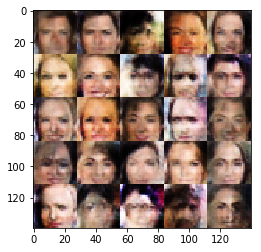

Epoch 1/1... Discriminator Loss: 1.3434... Generator Loss: 0.8378
Epoch 1/1... Discriminator Loss: 1.3275... Generator Loss: 1.0265
Epoch 1/1... Discriminator Loss: 1.3654... Generator Loss: 0.6698
Epoch 1/1... Discriminator Loss: 1.3032... Generator Loss: 0.8146
Epoch 1/1... Discriminator Loss: 1.3469... Generator Loss: 0.8237
Epoch 1/1... Discriminator Loss: 1.3555... Generator Loss: 0.7812
Epoch 1/1... Discriminator Loss: 1.3509... Generator Loss: 0.7847
Epoch 1/1... Discriminator Loss: 1.3231... Generator Loss: 0.8404
Epoch 1/1... Discriminator Loss: 1.4154... Generator Loss: 0.6596
Epoch 1/1... Discriminator Loss: 1.3136... Generator Loss: 0.8326


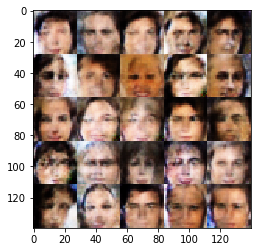

Epoch 1/1... Discriminator Loss: 1.2792... Generator Loss: 0.8223
Epoch 1/1... Discriminator Loss: 1.3586... Generator Loss: 0.7588
Epoch 1/1... Discriminator Loss: 1.2734... Generator Loss: 0.9153
Epoch 1/1... Discriminator Loss: 1.3502... Generator Loss: 0.8325
Epoch 1/1... Discriminator Loss: 1.3162... Generator Loss: 0.8150
Epoch 1/1... Discriminator Loss: 1.3987... Generator Loss: 0.8326
Epoch 1/1... Discriminator Loss: 1.3380... Generator Loss: 0.7330
Epoch 1/1... Discriminator Loss: 1.3061... Generator Loss: 0.8439
Epoch 1/1... Discriminator Loss: 1.4325... Generator Loss: 0.6516
Epoch 1/1... Discriminator Loss: 1.3238... Generator Loss: 0.8266


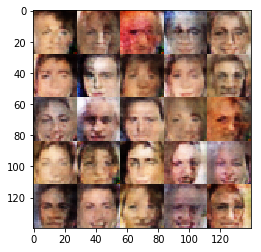

Epoch 1/1... Discriminator Loss: 1.3052... Generator Loss: 0.8217
Epoch 1/1... Discriminator Loss: 1.2950... Generator Loss: 0.8680
Epoch 1/1... Discriminator Loss: 1.2303... Generator Loss: 0.8925
Epoch 1/1... Discriminator Loss: 1.3632... Generator Loss: 0.7811
Epoch 1/1... Discriminator Loss: 1.2982... Generator Loss: 0.8869
Epoch 1/1... Discriminator Loss: 1.3129... Generator Loss: 0.9116
Epoch 1/1... Discriminator Loss: 1.2961... Generator Loss: 0.8934
Epoch 1/1... Discriminator Loss: 1.3312... Generator Loss: 0.8463
Epoch 1/1... Discriminator Loss: 1.3510... Generator Loss: 0.8332
Epoch 1/1... Discriminator Loss: 1.3807... Generator Loss: 0.7162


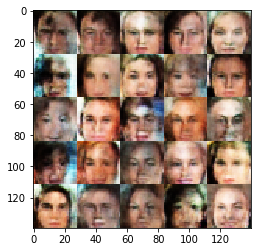

Epoch 1/1... Discriminator Loss: 1.3347... Generator Loss: 0.7839
Epoch 1/1... Discriminator Loss: 1.3179... Generator Loss: 0.7744
Epoch 1/1... Discriminator Loss: 1.3191... Generator Loss: 0.9758
Epoch 1/1... Discriminator Loss: 1.2698... Generator Loss: 0.7938
Epoch 1/1... Discriminator Loss: 1.3883... Generator Loss: 0.7916
Epoch 1/1... Discriminator Loss: 1.3053... Generator Loss: 0.7279
Epoch 1/1... Discriminator Loss: 1.3406... Generator Loss: 0.9004
Epoch 1/1... Discriminator Loss: 1.3907... Generator Loss: 0.9287
Epoch 1/1... Discriminator Loss: 1.3570... Generator Loss: 0.7799
Epoch 1/1... Discriminator Loss: 1.2832... Generator Loss: 0.7517


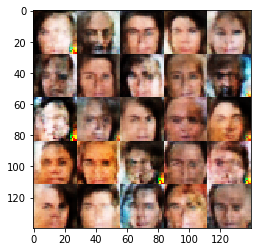

Epoch 1/1... Discriminator Loss: 1.3184... Generator Loss: 0.8849
Epoch 1/1... Discriminator Loss: 1.3242... Generator Loss: 0.7532
Epoch 1/1... Discriminator Loss: 1.2186... Generator Loss: 0.9144
Epoch 1/1... Discriminator Loss: 1.3314... Generator Loss: 0.9166
Epoch 1/1... Discriminator Loss: 1.2875... Generator Loss: 1.0114
Epoch 1/1... Discriminator Loss: 1.3448... Generator Loss: 0.8338
Epoch 1/1... Discriminator Loss: 1.3560... Generator Loss: 0.8294
Epoch 1/1... Discriminator Loss: 1.2623... Generator Loss: 0.7630
Epoch 1/1... Discriminator Loss: 1.3725... Generator Loss: 0.7711
Epoch 1/1... Discriminator Loss: 1.3042... Generator Loss: 0.9092


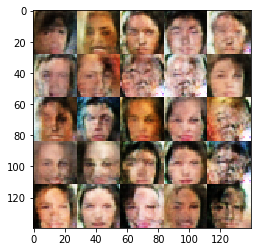

Epoch 1/1... Discriminator Loss: 1.2797... Generator Loss: 0.8959
Epoch 1/1... Discriminator Loss: 1.3750... Generator Loss: 0.9354
Epoch 1/1... Discriminator Loss: 1.3153... Generator Loss: 0.8413
Epoch 1/1... Discriminator Loss: 1.2959... Generator Loss: 0.9001
Epoch 1/1... Discriminator Loss: 1.5502... Generator Loss: 0.8673
Epoch 1/1... Discriminator Loss: 1.2739... Generator Loss: 0.8198
Epoch 1/1... Discriminator Loss: 1.2852... Generator Loss: 0.9221
Epoch 1/1... Discriminator Loss: 1.2915... Generator Loss: 0.7898
Epoch 1/1... Discriminator Loss: 1.2737... Generator Loss: 0.9138
Epoch 1/1... Discriminator Loss: 1.3173... Generator Loss: 0.7615


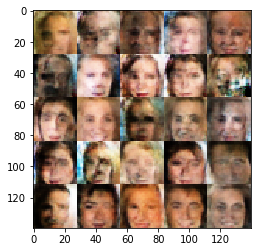

Epoch 1/1... Discriminator Loss: 1.3139... Generator Loss: 0.7944
Epoch 1/1... Discriminator Loss: 1.3661... Generator Loss: 0.8264
Epoch 1/1... Discriminator Loss: 1.3126... Generator Loss: 0.7868
Epoch 1/1... Discriminator Loss: 1.3600... Generator Loss: 0.7578
Epoch 1/1... Discriminator Loss: 1.2722... Generator Loss: 0.8861
Epoch 1/1... Discriminator Loss: 1.3341... Generator Loss: 0.8402
Epoch 1/1... Discriminator Loss: 1.3618... Generator Loss: 0.9134
Epoch 1/1... Discriminator Loss: 1.3991... Generator Loss: 0.9253
Epoch 1/1... Discriminator Loss: 1.3211... Generator Loss: 0.8447
Epoch 1/1... Discriminator Loss: 1.3073... Generator Loss: 0.8961


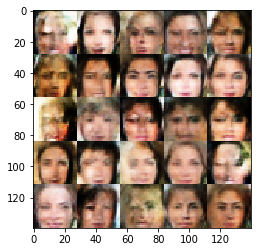

Epoch 1/1... Discriminator Loss: 1.2645... Generator Loss: 0.9889
Epoch 1/1... Discriminator Loss: 1.2832... Generator Loss: 0.8580
Epoch 1/1... Discriminator Loss: 1.3626... Generator Loss: 0.7172
Epoch 1/1... Discriminator Loss: 1.3291... Generator Loss: 0.7765
Epoch 1/1... Discriminator Loss: 1.3778... Generator Loss: 0.8612
Epoch 1/1... Discriminator Loss: 1.4293... Generator Loss: 0.7330
Epoch 1/1... Discriminator Loss: 1.4682... Generator Loss: 0.7603
Epoch 1/1... Discriminator Loss: 1.3318... Generator Loss: 0.8680
Epoch 1/1... Discriminator Loss: 1.3126... Generator Loss: 0.7856
Epoch 1/1... Discriminator Loss: 1.2809... Generator Loss: 0.8779


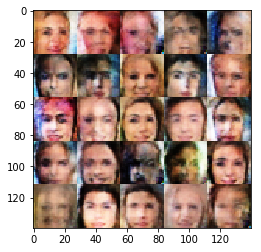

Epoch 1/1... Discriminator Loss: 1.3421... Generator Loss: 0.8404
Epoch 1/1... Discriminator Loss: 1.4259... Generator Loss: 0.5844
Epoch 1/1... Discriminator Loss: 1.2776... Generator Loss: 0.8234
Epoch 1/1... Discriminator Loss: 1.3621... Generator Loss: 1.0524
Epoch 1/1... Discriminator Loss: 1.3369... Generator Loss: 0.9201
Epoch 1/1... Discriminator Loss: 1.2652... Generator Loss: 0.7877
Epoch 1/1... Discriminator Loss: 1.3087... Generator Loss: 0.7169
Epoch 1/1... Discriminator Loss: 1.4631... Generator Loss: 0.9984
Epoch 1/1... Discriminator Loss: 1.3387... Generator Loss: 0.7651
Epoch 1/1... Discriminator Loss: 1.2939... Generator Loss: 0.8295


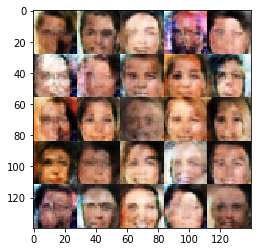

Epoch 1/1... Discriminator Loss: 1.3299... Generator Loss: 0.8301
Epoch 1/1... Discriminator Loss: 1.3520... Generator Loss: 0.7706
Epoch 1/1... Discriminator Loss: 1.3373... Generator Loss: 0.8476


In [23]:
batch_size  = 32
z_dim = 100
learning_rate = 0.0004
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.